In [ ]:
#pip install numpy pandas matplotlib seaborn scikit-fuzzy jupyter ipython

# Fuzzy Demand Classification & Scheduling
### **Problem statement:** How can household energy consumption be classified into low, medium, and high demand levels to enable cost optimization?

- **Goal 1:** Track electricity waste in lights for idle rooms.
- **Goal 2:** Detect the most expensive electricity use habits.


# 1. Import Data + fuzzify

1. Load data and summarize appliances in selected categories.
2. Fuzzy inputs:
| Column name    | Type                            | Note                    |
| ----------------- | ------------------------------- | ----------------------- |
| **KitchenActivity**   | low/med/high                    | Sum of all kitchen utilities - fuzzified    |
| **KitchenLights**     | off/low/med/high                | Sum of all kitchen lights - fuzzified   |
| **LoungeActivity**    | low/med/high                    | Sum of all lounge utilities - fuzzified |
| **LoungeLights**      | off/low/med/high                | Sum of all lounge lights - fuzzified    |
| **TimeOfDay**         | morning/afternoon/evening/night | Fuzzification of `hour` column  |
| **ElectricityPrices** | low/med/high                    | Fuzzification of `spot_price` column  |

#### 1.1 Import the necessary libraries

In [2]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl


#### 1.2 Load the CSV files, groups the appliances into four category. Keeps only the aggregated column category columns plus price and time. Finally displays the first 5 rows.

In [3]:
# load clean csv
file_path = "data/house1_clean_with_elprices.csv"
data = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")

# column metadata - categories
data.attrs["categories"] = {
    "kitchen_activity": ["breadmaker", "coffee_machine", "dishwasher", "fridge", "gas_oven", "kettle", "kitchen_phone&stereo", "kitchen_radio", "microwave", "toaster"],
    "kitchen_lights": ["kitchen_lights", "kitchen_dt_lamp", "kitchen_lamp2"],
    "lounge_activity": ["amp_livingroom", "DAB_radio_livingroom", "htpc", "iPad_charger","subwoofer_livingroom", "tv"],
    "lounge_lights": ["livingroom_s_lamp", "livingroom_s_lamp2", "livingroom_lamp_tv"]
}

# add columns for sum of appliances in each defined category
for category_name, appliance_list in data.attrs["categories"].items():
    # sum all matching columns to create one aggregate category
    data[category_name] = data[appliance_list].sum(axis=1)

# define columns to keep
columns_to_keep = [
    "kitchen_lights",
    "kitchen_activity",
    "lounge_activity",
    "lounge_lights",
    "spot_price",
    "hour",
    "month",
    "day"
]

data = data[columns_to_keep]

data.head()

,kitchen_lights,kitchen_activity,lounge_activity,lounge_lights,spot_price,hour,month,day
timestamp,,,,,,,,
2013-01-01 00:00:00,0.0,91.800,186.400,0.0,0.754,0,1,1
2013-01-01 00:01:00,0.0,91.600,200.600,0.0,0.754,0,1,1
2013-01-01 00:02:00,0.0,91.600,194.111,0.0,0.754,0,1,1
2013-01-01 00:03:00,0.0,91.889,190.600,0.0,0.754,0,1,1
2013-01-01 00:04:00,0.0,91.800,184.300,0.0,0.754,0,1,1


#### 1.3 Gives the summary statistics per column. Helps to define Triangular Membership function.

In [4]:
data.columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
kitchen_lights,525600.0,24.465452,68.625295,0.000,0.000,0.111,18.000,537.143
kitchen_activity,525600.0,89.101849,282.900222,0.000,8.000,9.444,95.722,5339.911
lounge_activity,525600.0,31.032340,60.993055,0.000,3.222,3.500,8.444,581.588
lounge_lights,525600.0,2.494083,7.134484,0.000,0.000,0.000,0.000,410.600
spot_price,525540.0,0.608424,0.480199,-0.707,0.337,0.546,0.807,7.797
hour,525600.0,11.500000,6.922193,0.000,5.750,11.500,17.250,23.000
month,525600.0,6.526027,3.447855,1.000,4.000,7.000,10.000,12.000
day,525600.0,15.720548,8.796255,1.000,8.000,16.000,23.000,31.000


## 2. Define TML membership functions

1. Define fuzzy set boundaries
2. Apply fuzzy sets to each column

### 2.1 Define fuzzy sets

**Note:**
- same fuzzy set for light columns: `['kitchen_lights', 'lounge_lights']`
- same fuzzy set for activity columns: `['kitchen_activity', 'lounge_activity']`
- individual fuzzy set for `time_of_day`
- individual fuzzy set for `electricity_prices`

In [5]:
# fuzzy limits for light columns for kitchen and lounge
lights_limits = {
    "off": (0, 0, 1.5),
    "low": (0.5, 5, 20),
    "medium": (15, 50, 150),
    "high": (120, 300, 550)
}

# fuzzy limits for activity columns for kitchen and lounge
activity_limits = {
    "low": (0, 0, 20),
    "medium": (10, 100, 400),
    "high": (300, 1000, 5000)
}

# fuzzy limits for time of day
time_of_day = {
    "night": (0, 3, 6),
    "morning": (5, 8, 11),
    "afternoon": (10, 14, 18),
    "evening": (17, 20, 24)
}

# fuzzy limits for spot prices
electricity_prices = {
    "low": (0, 0.3, 0.6),
    "medium": (0.3, 0.8, 1.5),
    "high": (1.0, 2.5, 5.0)
}

#### 2.2 Define triangular membership function
<br>
<br>
The **triangular fuzzy membership function** is defined as:

$$
\mu(x; a, b, c) =
\begin{cases}
0, & x \le a \\
\dfrac{x - a}{b - a}, & a < x \le b \\
\dfrac{c - x}{c - b}, & b < x < c \\
0, & x \ge c
\end{cases}
$$

Where:

- \( a \) = left base
- \( b \) = peak (membership = 1)
- \( c \) = right base


In [6]:
def triangular_membership(x, a, b, c):
    """
    General triangle fuzzy membership function.

    :param x: array-like or scalar: Input value(s)
    :param a: float:                left base of triangle
    :param b: float:                peak of triangle
    :param c: float:                right base of triangle
    :param circular: bool:          optional: circular fuzzy set (default: False)
    :param period: float:           optional: cycle length of circular variables (default=24 for hours)
    :return: array-like or scalar:  triangle fuzzy membership
    """
    x = np.asarray(x, dtype=float)

    # initialize array with zeros in shape of x
    mu = np.zeros_like(x)

    # rising edge of triangle, selects a value strictly between a and b
    rising = (x > a) & (x <= b)
    mu[rising] = (x[rising] - a) / (b - a)

    # falling edge of triangle, selects a value strictly between b and c
    falling = (x > b) & (x < c)
    mu[falling] = (c - x[falling]) / (c - b)

    # everything else = 0
    return mu

### 2.3 Apply TMFs to fuzzy sets

In [7]:
# For each column and label, take the crisp values and calculate how strongly each timestamp's belong to
# label using the TMF. It gives a serious of membership degrees between 0 and 1. Repeat this for all the
# labels, so one raw column becomes several fuzzy membership columns. Doing this across lights, activity,
# hrs and spot prices builds the full fuzzified DataFrame.

fuzzy_dict = {}

# lights
for col in ["kitchen_lights", "lounge_lights"]:
    for label, (a, b, c) in lights_limits.items():
        fuzzy_dict[f"{col}_{label}"] = triangular_membership(data[col], a, b, c)

# activity
for col in ["kitchen_activity", "lounge_activity"]:
    for label, (a, b, c) in activity_limits.items():
        fuzzy_dict[f"{col}_{label}"] = triangular_membership(data[col], a, b, c)

# time of day
for label, (a, b, c) in time_of_day.items():
    fuzzy_dict[f"time_{label}"] = triangular_membership(data["hour"], a, b, c)

# electricity
for label, (a, b, c) in electricity_prices.items():
    fuzzy_dict[f"spot_price_{label}"] = triangular_membership(data["spot_price"], a, b, c)

# create new fuzzified df
fuzzy_data = pd.DataFrame(fuzzy_dict, index=data.index)

# keep 'day', 'month', 'hour' columns for analysis
fuzzy_data[["day", "month", "hour"]] = data[["day", "month", "hour"]]

fuzzy_data.head()

,kitchen_lights_off,kitchen_lights_low,kitchen_lights_medium,kitchen_lights_high,lounge_lights_off,lounge_lights_low,lounge_lights_medium,lounge_lights_high,kitchen_activity_low,kitchen_activity_medium,...,time_night,time_morning,time_afternoon,time_evening,spot_price_low,spot_price_medium,spot_price_high,day,month,hour
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.908889,...,0.0,0.0,0.0,0.0,0.0,0.908,0.0,1,1,0
2013-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.906667,...,0.0,0.0,0.0,0.0,0.0,0.908,0.0,1,1,0
2013-01-01 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.906667,...,0.0,0.0,0.0,0.0,0.0,0.908,0.0,1,1,0
2013-01-01 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909878,...,0.0,0.0,0.0,0.0,0.0,0.908,0.0,1,1,0
2013-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.908889,...,0.0,0.0,0.0,0.0,0.0,0.908,0.0,1,1,0


### 2.4 Visualization of TMFs

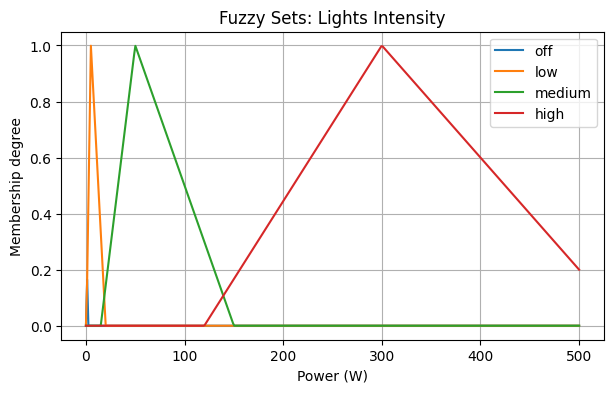

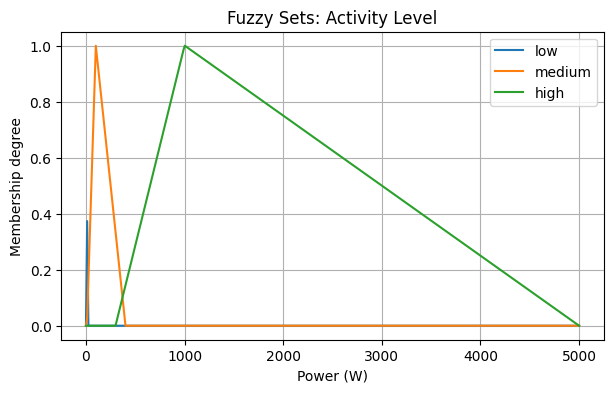

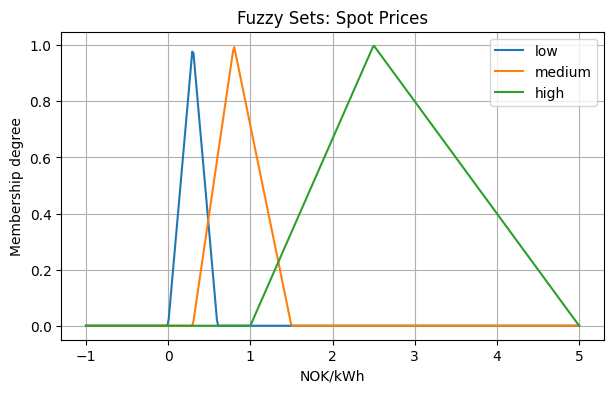

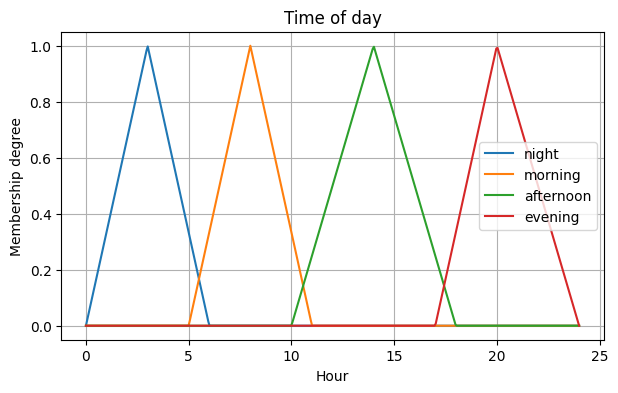

In [8]:
'''
Generates x values over a specified range, computes each label's TM curve (a,b,c), and plots
them with the grid and legend. Called four times to visualize the fuzzy sets for lights, activity,
time of the day and spot prices.
'''
def plot_membership_set(x_range, limits_dict, title, xlabel):
    plt.figure(figsize=(7,4))
    x = np.linspace(*x_range, 400)
    for label, (a, b, c) in limits_dict.items():
        y = triangular_membership(x, a, b, c)
        plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Membership degree")
    plt.legend()
    plt.grid(True)
    plt.show()

# lights
plot_membership_set((0, 500), lights_limits, "Fuzzy Sets: Lights Intensity", "Power (W)")
# activity
plot_membership_set((0, 5000), activity_limits, "Fuzzy Sets: Activity Level", "Power (W)")
# spot prices
plot_membership_set((-1, 5), electricity_prices, "Fuzzy Sets: Spot Prices", "NOK/kWh")
# time of day
plot_membership_set((0, 24), time_of_day, "Time of day", "Hour")


#### 2.5 Grid of real data distribution in fuzzy memberships:

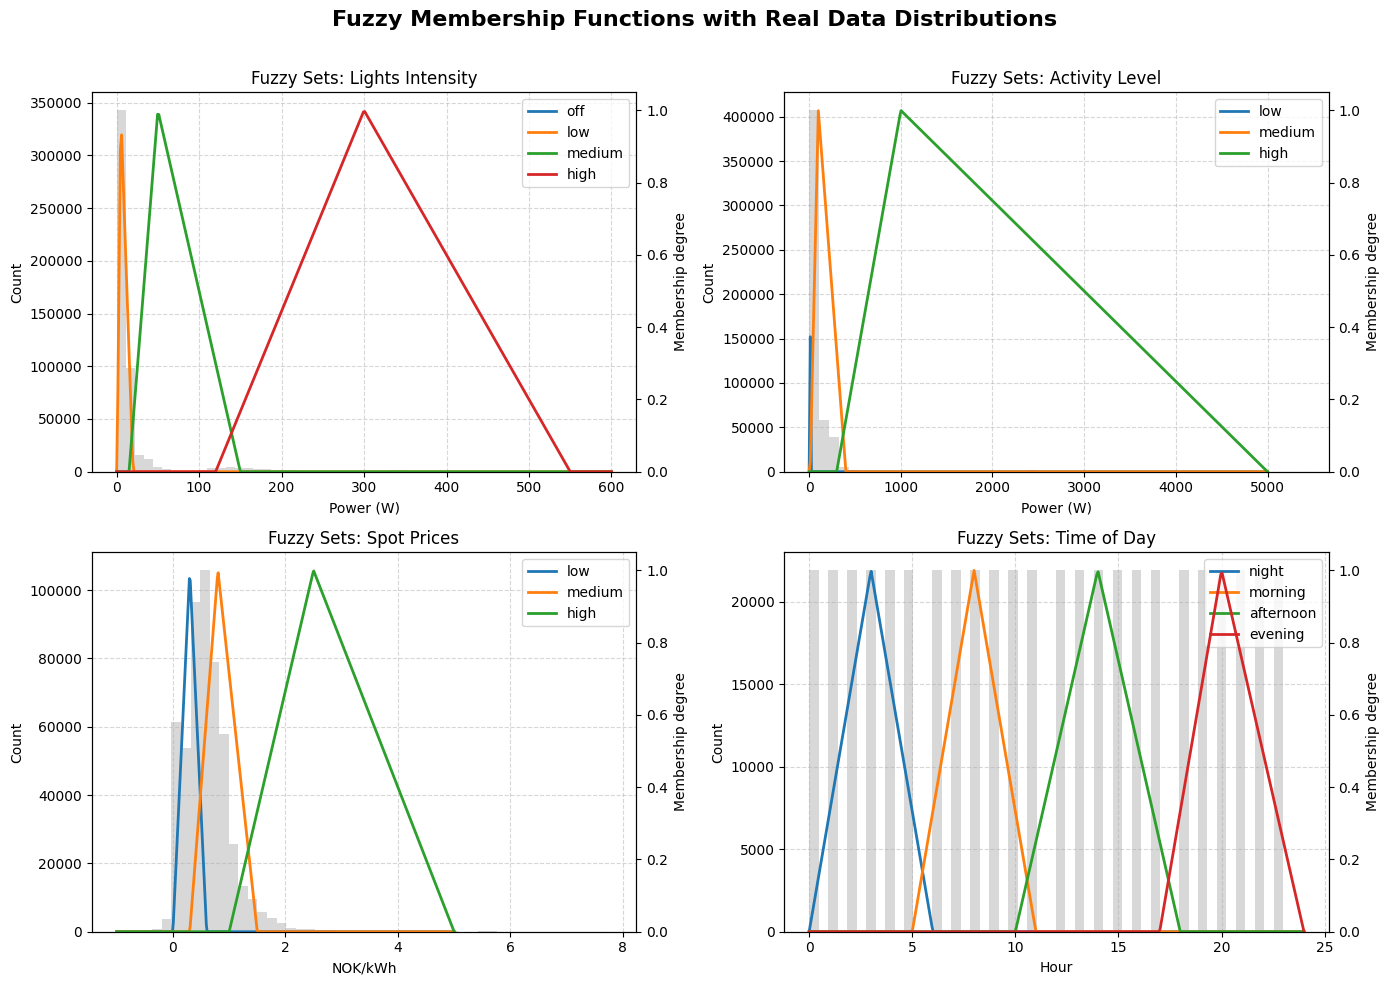

In [9]:
'''
Creates a 2x2 grid of histograms (lights, activity, sport price, hour) and overlays each with its TMF
curves - showing how real data distributes relative to the defined fuzzy sets.
'''
def plot_membership_grid_with_hist(data, lights_limits, activity_limits, electricity_prices, time_of_day):
    """
    Create a 2x2 grid of raw histograms overlaid with fuzzy membership functions.
    """

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # --- Subplot 1: Lights ---
    ax1 = axes[0, 0]
    ax2 = ax1.twinx()
    lights_data = data["kitchen_lights"].values + data["lounge_lights"].values
    x = np.linspace(0, 600, 400)
    ax1.hist(lights_data, bins=50, alpha=0.3, color='grey', label="Data distribution")
    for label, (a, b, c) in lights_limits.items():
        y = triangular_membership(x, a, b, c)
        ax2.plot(x, y, label=label, linewidth=2)
    ax1.set_title("Fuzzy Sets: Lights Intensity")
    ax1.set_xlabel("Power (W)")
    ax1.set_ylabel("Count")
    ax2.set_ylabel("Membership degree")
    ax2.set_ylim(0, 1.05)
    lines, labels = ax2.get_legend_handles_labels()
    ax1.legend(lines, labels, loc="upper right")
    ax1.grid(True, linestyle='--', alpha=0.5)

    # --- Subplot 2: Activity ---
    ax1 = axes[0, 1]
    ax2 = ax1.twinx()
    activity_data = data["kitchen_activity"].values + data["lounge_activity"].values
    x = np.linspace(0, 5000, 400)
    ax1.hist(activity_data, bins=50, alpha=0.3, color='grey', label="Data distribution")
    for label, (a, b, c) in activity_limits.items():
        y = triangular_membership(x, a, b, c)
        ax2.plot(x, y, label=label, linewidth=2)
    ax1.set_title("Fuzzy Sets: Activity Level")
    ax1.set_xlabel("Power (W)")
    ax1.set_ylabel("Count")
    ax2.set_ylabel("Membership degree")
    ax2.set_ylim(0, 1.05)
    lines, labels = ax2.get_legend_handles_labels()
    ax1.legend(lines, labels, loc="upper right")
    ax1.grid(True, linestyle='--', alpha=0.5)

    # --- Subplot 3: Spot Prices ---
    ax1 = axes[1, 0]
    ax2 = ax1.twinx()
    price_data = data["spot_price"].values
    x = np.linspace(-1, 5, 400)
    ax1.hist(price_data, bins=50, alpha=0.3, color='grey', label="Data distribution")
    for label, (a, b, c) in electricity_prices.items():
        y = triangular_membership(x, a, b, c)
        ax2.plot(x, y, label=label, linewidth=2)
    ax1.set_title("Fuzzy Sets: Spot Prices")
    ax1.set_xlabel("NOK/kWh")
    ax1.set_ylabel("Count")
    ax2.set_ylabel("Membership degree")
    ax2.set_ylim(0, 1.05)
    lines, labels = ax2.get_legend_handles_labels()
    ax1.legend(lines, labels, loc="upper right")
    ax1.grid(True, linestyle='--', alpha=0.5)

    # --- Subplot 4: Time of Day ---
    ax1 = axes[1, 1]
    ax2 = ax1.twinx()
    time_data = data["hour"].values
    x = np.linspace(0, 24, 400)
    ax1.hist(time_data, bins=50, alpha=0.3, color='grey', label="Data distribution")
    for label, (a, b, c) in time_of_day.items():
        y = triangular_membership(x, a, b, c)
        ax2.plot(x, y, label=label, linewidth=2)
    ax1.set_title("Fuzzy Sets: Time of Day")
    ax1.set_xlabel("Hour")
    ax1.set_ylabel("Count")
    ax2.set_ylabel("Membership degree")
    ax2.set_ylim(0, 1.05)
    lines, labels = ax2.get_legend_handles_labels()
    ax1.legend(lines, labels, loc="upper right")
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Global figure title
    fig.suptitle("Fuzzy Membership Functions with Real Data Distributions", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=(0, 0, 1, 0.97))
    plt.show()

plot_membership_grid_with_hist(
    data,
    lights_limits=lights_limits,
    activity_limits=activity_limits,
    electricity_prices=electricity_prices,
    time_of_day=time_of_day
)


#### 2.6 Plot membership distribution between all fuzzy sets

Grouped by hour on mean.

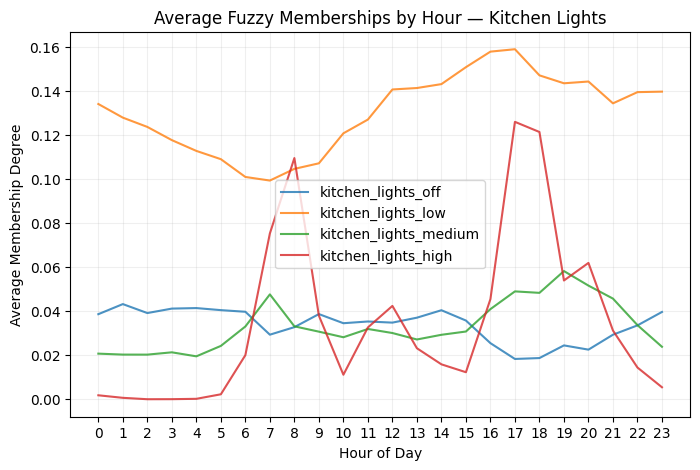

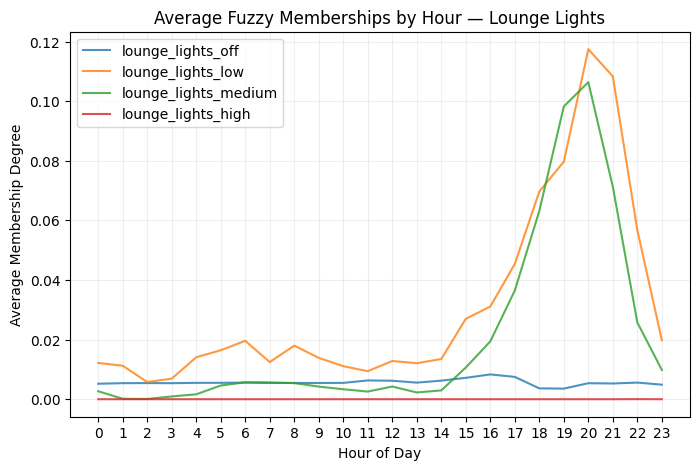

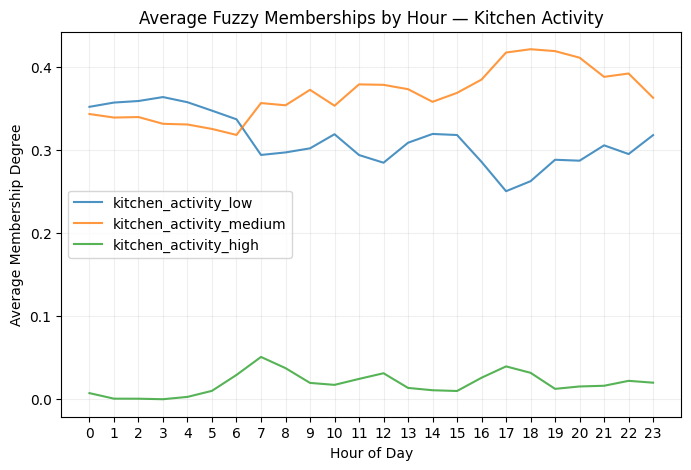

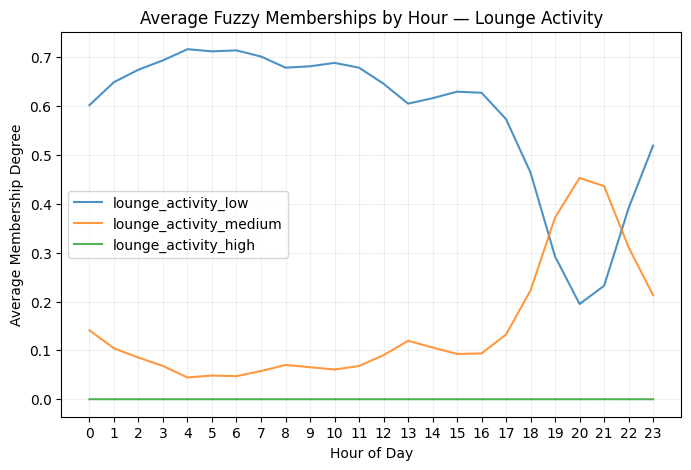

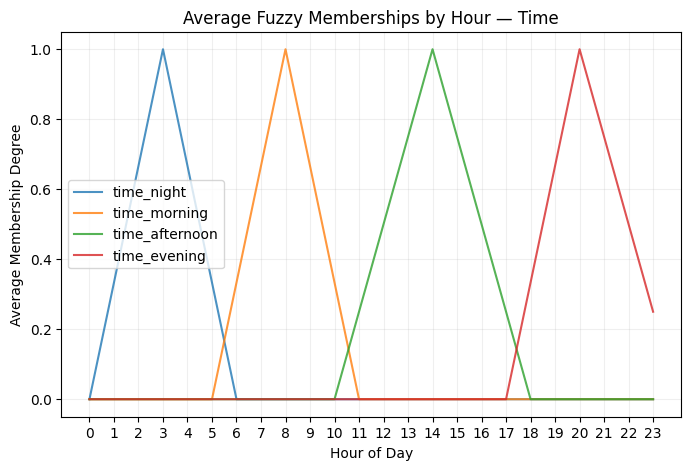

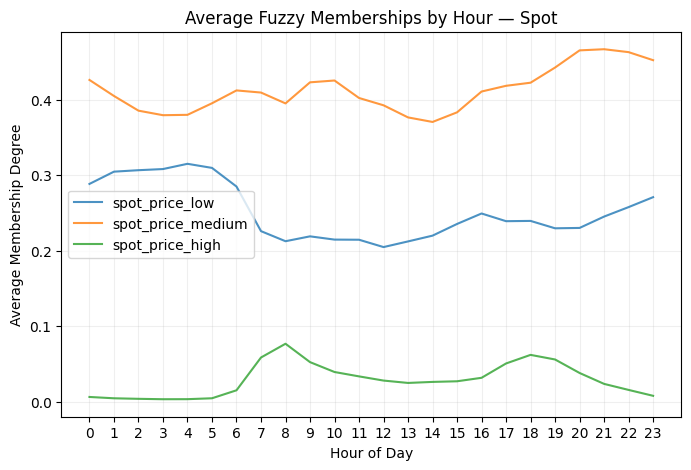

In [10]:
# It averages all fuzzy membership column by hour, then groups related columns and plots each groups
#hourly average membership curves. The result shows daily patterns for each category.

# group by hour to look at daily patterns
fuzzy_by_hour = fuzzy_data.groupby("hour").mean()

# extract relevant columns by membership
fuzzy_by_hour = fuzzy_by_hour.filter(regex="kitchen_|lounge_|spot_price_|time_")

# identify membership groups
# (groups of columns - e.g. 'kitchen_activity_low', 'kitchen_activity_medium' etc.)
fuzzy_groups = {}
for col in fuzzy_by_hour.columns:
    group = "_".join(col.split("_")[:2]) if "time_" not in col and "spot_price_" not in col else col.split("_")[0]
    fuzzy_groups.setdefault(group, []).append(col)

# plot average hourly memberships per category
for group_name, cols in fuzzy_groups.items():
    plt.figure(figsize=(8,5))
    fuzzy_by_hour[cols].plot(ax=plt.gca(), alpha=0.8)
    plt.title(f"Average Fuzzy Memberships by Hour — {group_name.replace('_', ' ').title()}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Membership Degree")
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

# 3. Fuzzy Rules

<details>
<summary><b>Rule set (click to expand)</b></summary>

<div style="font-size: 90%; line-height: 1.3;">

Rules for energy waste / immediate waste detection

- IF lights = high AND activity = low THEN energy_waste_score = high.
- IF lights = medium AND activity = low THEN energy_waste_score = medium.
- IF lights = off THEN energy_waste_score = low (acceptable, no lighting waste).
- IF lights = low AND activity = none THEN energy_waste_score = low (residual low-level waste that can still be eliminated).
- IF lights = high AND time_of_day = night AND activity = low THEN energy_waste_score = high (priority: very wasteful at night).

Why refined? Previously "activity = none" alone forced LOW even if lights were still on (e.g. high + none). That masked residual lighting waste. Now LOW means either truly off or only low lights while idle.

Rules for kitchen light efficiency

- IF kitchen_lights = high AND activity = low THEN kitchen_light_efficiency = very_poor.
- IF lights = medium AND activity = medium THEN kitchen_light_efficiency = fair.
- IF lights = low AND activity = high THEN kitchen_light_efficiency = very_good.
- IF lights = off AND activity = low OR (morning AND activity = high AND lights = low) THEN kitchen_light_efficiency = good.

Rules for habit cost (price × usage)

- IF electricity_prices = high AND activity = high THEN habit_cost = high.
- IF electricity_prices = medium AND activity = high THEN habit_cost = medium.
- IF electricity_prices = low AND activity = low THEN habit_cost = low.
- IF time_of_day = afternoon AND electricity_prices = high AND activity = medium THEN habit_cost = high (peak-pricing sensitivity).
- IF time_of_day = evening AND electricity_prices = high AND activity = high THEN habit_cost = high.

Rules combining waste, cost and efficiency → overall

- IF energy_waste_score = high AND habit_cost = high THEN overall_efficiency = poor.
- IF energy_waste_score = medium AND habit_cost = medium THEN overall_efficiency = fair.
- IF energy_waste_score = low AND habit_cost = low THEN overall_efficiency = excellent.
- IF time_of_day = night AND lights = high AND activity = low THEN overall_efficiency = poor.

Time-of-day specific / behavioral rules

- Morning: high activity with low lights = efficient (natural light usage boosts good efficiency).

Residual waste guidance

If you see low waste but lights still slightly on while nobody's active (low lights + none activity), you can further reduce consumption by turning them fully off. Adjust recommendation sensitivity by:
- Lowering on_threshold (e.g. 0.3) to include very low light states.
- Lowering idle_threshold (e.g. 0.5) to catch borderline idle.
- Lowering decision_threshold (e.g. 0.5) so residual waste becomes actionable.

<em>Note:</em> Activity = none is the complement NOT(max(low, medium, high)).

</div>
</details>

Mamdani-style fuzzy rule computation:
1. Track electricity waste in lights for idle rooms.
2. Detect expensive energy habits.
3. Derive overall household efficiency.

In [11]:

def compute_mamdani_rules(fuzzy_data: pd.DataFrame) -> pd.DataFrame:
    """Compute Mamdani fuzzy rule outputs (membership values) from fuzzified inputs."""

    # fuzzy operators, np asarray converts inputs (list, numpy arrays, pandas series)
    # to numpy arrays, for fast and consistent.
    def fuzz_and(*args):
        return np.minimum.reduce([np.asarray(a) for a in args])

    def fuzz_or(*args):
        return np.maximum.reduce([np.asarray(a) for a in args])

    def fuzz_not(a):
        return 1 - np.asarray(a)


    # household-level lights (OR across rooms) — used for some overall rules/metrics
    lights_off    = fuzz_or(fuzzy_data['kitchen_lights_off'], fuzzy_data['lounge_lights_off'])
    lights_low    = fuzz_or(fuzzy_data['kitchen_lights_low'], fuzzy_data['lounge_lights_low'])
    lights_medium = fuzz_or(fuzzy_data['kitchen_lights_medium'], fuzzy_data['lounge_lights_medium'])
    lights_high   = fuzz_or(fuzzy_data['kitchen_lights_high'], fuzzy_data['lounge_lights_high'])

    # household-level activity (OR across rooms) — kept for backward compatibility
    activity_low_hh    = fuzz_or(fuzzy_data['kitchen_activity_low'], fuzzy_data['lounge_activity_low'])
    activity_medium_hh = fuzz_or(fuzzy_data['kitchen_activity_medium'], fuzzy_data['lounge_activity_medium'])
    activity_high_hh   = fuzz_or(fuzzy_data['kitchen_activity_high'], fuzzy_data['lounge_activity_high'])
    activity_none_hh   = fuzz_not(fuzz_or(activity_low_hh, activity_medium_hh, activity_high_hh))

    # time of day
    time_night     = fuzzy_data['time_night']
    time_morning   = fuzzy_data['time_morning']
    time_afternoon = fuzzy_data['time_afternoon']
    time_evening   = fuzzy_data['time_evening']

    # prices
    price_low    = fuzzy_data['spot_price_low']
    price_medium = fuzzy_data['spot_price_medium']
    price_high   = fuzzy_data['spot_price_high']

    # Per-room lights
    kitchen_off = fuzzy_data['kitchen_lights_off']
    kitchen_low = fuzzy_data['kitchen_lights_low']
    kitchen_medium = fuzzy_data['kitchen_lights_medium']
    kitchen_high = fuzzy_data['kitchen_lights_high']

    lounge_off = fuzzy_data['lounge_lights_off']
    lounge_low = fuzzy_data['lounge_lights_low']
    lounge_medium = fuzzy_data['lounge_lights_medium']
    lounge_high = fuzzy_data['lounge_lights_high']

    # Per-room activity
    kitchen_activity_low = fuzzy_data['kitchen_activity_low']
    kitchen_activity_medium = fuzzy_data['kitchen_activity_medium']
    kitchen_activity_high = fuzzy_data['kitchen_activity_high']
    kitchen_activity_none = np.clip(
        fuzz_not(fuzz_or(kitchen_activity_low, kitchen_activity_medium, kitchen_activity_high)), 0, 1
    )

    lounge_activity_low = fuzzy_data['lounge_activity_low']
    lounge_activity_medium = fuzzy_data['lounge_activity_medium']
    lounge_activity_high = fuzzy_data['lounge_activity_high']
    lounge_activity_none = np.clip(
        fuzz_not(fuzz_or(lounge_activity_low, lounge_activity_medium, lounge_activity_high)), 0, 1
    )


    # -------- Refined energy waste semantics --------
    # "Low" = off or minimal light during inactivity.
    kitchen_energy_waste_low = fuzz_or(kitchen_off, fuzz_and(kitchen_low, kitchen_activity_none))
    kitchen_energy_waste_medium = fuzz_and(kitchen_medium, kitchen_activity_low)
    kitchen_energy_waste_high = fuzz_or(
        fuzz_and(kitchen_high, kitchen_activity_low),
        fuzz_and(kitchen_high, time_night, kitchen_activity_low)
    )
    lounge_energy_waste_low = fuzz_or(lounge_off, fuzz_and(lounge_low, lounge_activity_none))

    # ADJUSTED: allow idle (activity_none) OR low activity for medium/high lounge waste
    lounge_idle_or_low = fuzz_or(lounge_activity_low, lounge_activity_none)
    lounge_energy_waste_medium = fuzz_and(lounge_medium, lounge_idle_or_low)
    lounge_energy_waste_high = fuzz_or(
        fuzz_and(lounge_high, lounge_idle_or_low),
        fuzz_and(lounge_high, time_night, lounge_idle_or_low)
    )

    # Household-level Energy waste (OR-aggregate of room-specific) — preserves existing behavior
    energy_waste_low = fuzz_or(kitchen_energy_waste_low, lounge_energy_waste_low)
    energy_waste_medium = fuzz_or(kitchen_energy_waste_medium, lounge_energy_waste_medium)
    energy_waste_high = fuzz_or(kitchen_energy_waste_high, lounge_energy_waste_high)

    # Kitchen light efficiency (unchanged; kitchen-only)
    kitchen_light_efficiency_very_poor = fuzz_and(kitchen_high, kitchen_activity_low)
    kitchen_light_efficiency_fair = fuzz_and(kitchen_medium, kitchen_activity_medium)
    kitchen_light_efficiency_very_good = fuzz_and(kitchen_low, kitchen_activity_high)
    kitchen_light_efficiency_good = fuzz_and(kitchen_off, kitchen_activity_low)
    kitchen_light_efficiency_good = np.maximum(
        kitchen_light_efficiency_good,
        fuzz_and(time_morning, kitchen_activity_high, kitchen_low)
    )

    # Habit cost (price × usage) — household-level activity retained
    habit_cost_high = fuzz_or(
        fuzz_and(price_high, activity_high_hh),
        fuzz_and(time_afternoon, price_high, activity_medium_hh),
        fuzz_and(time_evening, price_high, activity_high_hh)
    )
    habit_cost_medium = fuzz_and(price_medium, activity_high_hh)
    habit_cost_low = fuzz_and(price_low, activity_low_hh)

    # Overall efficiency — uses household-level waste and prices
    overall_efficiency_poor = fuzz_or(
        fuzz_and(energy_waste_high, habit_cost_high),
        fuzz_and(time_night, lights_high, activity_low_hh)
    )
    overall_efficiency_fair = fuzz_and(energy_waste_medium, habit_cost_medium)
    overall_efficiency_excellent = fuzz_and(energy_waste_low, habit_cost_low)


    # Assemble
    return pd.DataFrame({
        # Room-specific energy waste
        'kitchen_energy_waste_low': kitchen_energy_waste_low,
        'kitchen_energy_waste_medium': kitchen_energy_waste_medium,
        'kitchen_energy_waste_high': kitchen_energy_waste_high,
        'lounge_energy_waste_low': lounge_energy_waste_low,
        'lounge_energy_waste_medium': lounge_energy_waste_medium,
        'lounge_energy_waste_high': lounge_energy_waste_high,

        # Household-level energy waste (aggregated)
        'energy_waste_low': energy_waste_low,
        'energy_waste_medium': energy_waste_medium,
        'energy_waste_high': energy_waste_high,

        # Kitchen light efficiency
        'kitchen_light_efficiency_very_poor': kitchen_light_efficiency_very_poor,
        'kitchen_light_efficiency_fair': kitchen_light_efficiency_fair,
        'kitchen_light_efficiency_very_good': kitchen_light_efficiency_very_good,
        'kitchen_light_efficiency_good': kitchen_light_efficiency_good,

        # Habit cost
        'habit_cost_low': habit_cost_low,
        'habit_cost_medium': habit_cost_medium,
        'habit_cost_high': habit_cost_high,

        # Overall efficiency
        'overall_efficiency_poor': overall_efficiency_poor,
        'overall_efficiency_fair': overall_efficiency_fair,
        'overall_efficiency_excellent': overall_efficiency_excellent
    }, index=fuzzy_data.index)


# Example usage (last 24 rows)
fuzzy_rules_fn = compute_mamdani_rules(fuzzy_data)
fuzzy_rules_fn.tail(24)

,kitchen_energy_waste_low,kitchen_energy_waste_medium,kitchen_energy_waste_high,lounge_energy_waste_low,lounge_energy_waste_medium,lounge_energy_waste_high,energy_waste_low,energy_waste_medium,energy_waste_high,kitchen_light_efficiency_very_poor,kitchen_light_efficiency_fair,kitchen_light_efficiency_very_good,kitchen_light_efficiency_good,habit_cost_low,habit_cost_medium,habit_cost_high,overall_efficiency_poor,overall_efficiency_fair,overall_efficiency_excellent
timestamp,,,,,,,,,,,,,,,,,,,
2013-12-31 23:36:00,0.017289,0.000000,0.0,0.0,0.038983,0.0,0.017289,0.038983,0.0,0.0,0.088886,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2013-12-31 23:37:00,0.023611,0.000000,0.0,0.0,0.026250,0.0,0.023611,0.026250,0.0,0.0,0.085714,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2013-12-31 23:38:00,0.031544,0.000000,0.0,0.0,0.017500,0.0,0.031544,0.017500,0.0,0.0,0.085714,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2013-12-31 23:39:00,0.040744,0.000000,0.0,0.0,0.015973,0.0,0.040744,0.015973,0.0,0.0,0.085714,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2013-12-31 23:40:00,0.051389,0.000000,0.0,0.0,0.017083,0.0,0.051389,0.017083,0.0,0.0,0.085714,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2013-12-31 23:41:00,0.048811,0.000000,0.0,0.0,0.017323,0.0,0.048811,0.017323,0.0,0.0,0.085714,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2013-12-31 23:42:00,0.061111,0.000000,0.0,0.0,0.017407,0.0,0.061111,0.017407,0.0,0.0,0.085714,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2013-12-31 23:43:00,0.062956,0.000000,0.0,0.0,0.016297,0.0,0.062956,0.016297,0.0,0.0,0.085714,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000
2013-12-31 23:44:00,0.070633,0.000000,0.0,0.0,0.016250,0.0,0.070633,0.016250,0.0,0.0,0.085714,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000


# 3. Defuzzification (crisp scores)

We convert fuzzy memberships into single numeric (crisp) scores for ranking and downstream recommendation. We'll use a simple weighted-average (centroid approximation) for each output category:

Mapping of membership labels to numeric scale:
- Energy Waste: {low: 0, medium: 0.5, high: 1}
- Kitchen Light Efficiency: {very_poor: 0, fair: 0.4, good: 0.7, very_good: 1}
- Habit Cost: {low: 0, medium: 0.5, high: 1}
- Overall Efficiency: {poor: 0, fair: 0.5, excellent: 1}

Weighted average formula:

$$\text{Score} = \frac{\sum_i w_i \cdot \mu_i}{\sum_i \mu_i + \epsilon}$$

Where $\mu_i$ is the membership degree for label i, $w_i$ the weight for that label, and $\epsilon$ a small constant to avoid division by zero.

Interpretation:
- Energy Waste Score close to 1 ⇒ high waste (bad).
- Kitchen Light Efficiency close to 1 ⇒ very good (lights aligned with activity/time).
- Habit Cost Score close to 1 ⇒ expensive usage (bad, shift or reduce).
- Overall Efficiency close to 1 ⇒ excellent combined behavior.

We'll add crisp label columns using argmax across the fuzzy label memberships for explainability. After defuzzification we can sort hours by worst waste or highest cost to prioritize interventions.

In [12]:
# Converts fuzzy membership into crisp values using weighted average (waste, habit, cost, overall efficiency
# and kitchen efficiency) - derives the dominant label for each by argmax, and builds a composite priority
# (waste x cost). Then appends time columns, shows the first 24 rows, and produces an hourly mean summary.
# Ensure fuzzy_rules_fn exists
try:
    _ = fuzzy_rules_fn.head(1)
except NameError:
    fuzzy_rules_fn = compute_mamdani_rules(fuzzy_data)

# Mappings for weighted-average defuzzification
_waste_map = {
    'energy_waste_low': 0.0,
    'energy_waste_medium': 0.5,
    'energy_waste_high': 1.0,
}
_habit_map = {
    'habit_cost_low': 0.0,
    'habit_cost_medium': 0.5,
    'habit_cost_high': 1.0,
}
_overall_eff_map = {
    'overall_efficiency_poor': 0.0,
    'overall_efficiency_fair': 0.5,
    'overall_efficiency_excellent': 1.0,
}
_kitchen_eff_map = {
    'kitchen_light_efficiency_very_poor': 0.0,
    'kitchen_light_efficiency_fair': 0.4,
    'kitchen_light_efficiency_good': 0.7,
    'kitchen_light_efficiency_very_good': 1.0,
}


def _weighted_average_score(df: pd.DataFrame, mapping: dict) -> pd.Series:
    cols = list(mapping.keys())
    present = [c for c in cols if c in df.columns]
    if not present:
        return pd.Series(np.nan, index=df.index)
    weights = np.array([mapping[c] for c in present], dtype=float)
    mu = df[present].to_numpy(dtype=float)
    num = (mu * weights).sum(axis=1)
    den = mu.sum(axis=1) + 1e-12
    return pd.Series(num / den, index=df.index)

# Compute crisp scores
scores_df = pd.DataFrame(index=fuzzy_rules_fn.index)

scores_df['energy_waste_score'] = _weighted_average_score(fuzzy_rules_fn, _waste_map)
scores_df['habit_cost_score'] = _weighted_average_score(fuzzy_rules_fn, _habit_map)
scores_df['overall_efficiency_score'] = _weighted_average_score(fuzzy_rules_fn, _overall_eff_map)
scores_df['kitchen_light_efficiency_score'] = _weighted_average_score(fuzzy_rules_fn, _kitchen_eff_map)

# Dominant labels via argmax of memberships
scores_df['energy_waste_label'] = fuzzy_rules_fn[[c for c in _waste_map if c in fuzzy_rules_fn.columns]].idxmax(axis=1).str.replace('energy_waste_', '', regex=False)
scores_df['habit_cost_label'] = fuzzy_rules_fn[[c for c in _habit_map if c in fuzzy_rules_fn.columns]].idxmax(axis=1).str.replace('habit_cost_', '', regex=False)
scores_df['overall_efficiency_label'] = fuzzy_rules_fn[[c for c in _overall_eff_map if c in fuzzy_rules_fn.columns]].idxmax(axis=1).str.replace('overall_efficiency_', '', regex=False)
scores_df['kitchen_light_efficiency_label'] = (
    fuzzy_rules_fn[[c for c in _kitchen_eff_map if c in fuzzy_rules_fn.columns]]
    .idxmax(axis=1)
    .str.replace('kitchen_light_efficiency_', '', regex=False)
)

# Optional: composite priority for action — high waste during high price
scores_df['waste_cost_priority'] = scores_df['energy_waste_score'] * scores_df['habit_cost_score']

# Attach hour/day/month for grouping if available
for col in ['hour', 'day', 'month']:
    if col in fuzzy_data.columns:
        scores_df[col] = fuzzy_data[col]

# Preview
display(scores_df.head(24))

# Quick hourly summary (mean)
if 'hour' in scores_df.columns:
    display(scores_df.groupby('hour')[['energy_waste_score','habit_cost_score','overall_efficiency_score']].mean().round(3))

,energy_waste_score,habit_cost_score,overall_efficiency_score,kitchen_light_efficiency_score,energy_waste_label,habit_cost_label,overall_efficiency_label,kitchen_light_efficiency_label,waste_cost_priority,hour,day,month
timestamp,,,,,,,,,,,,
2013-01-01 00:00:00,0.0,0.0,0.0,0.0,low,low,poor,very_poor,0.0,0,1,1
2013-01-01 00:01:00,0.0,0.0,0.0,0.0,low,low,poor,very_poor,0.0,0,1,1
2013-01-01 00:02:00,0.0,0.0,0.0,0.0,low,low,poor,very_poor,0.0,0,1,1
2013-01-01 00:03:00,0.0,0.0,0.0,0.0,low,low,poor,very_poor,0.0,0,1,1
2013-01-01 00:04:00,0.0,0.0,0.0,0.0,low,low,poor,very_poor,0.0,0,1,1
2013-01-01 00:05:00,0.0,0.0,0.0,0.0,low,low,poor,very_poor,0.0,0,1,1
2013-01-01 00:06:00,0.0,0.0,0.0,0.0,low,low,poor,very_poor,0.0,0,1,1
2013-01-01 00:07:00,0.0,0.0,0.0,0.0,low,low,poor,very_poor,0.0,0,1,1
2013-01-01 00:08:00,0.0,0.0,0.0,0.0,low,low,poor,very_poor,0.0,0,1,1


,energy_waste_score,habit_cost_score,overall_efficiency_score
hour,,,
0,0.032,0.006,0.309
1,0.032,0.000,0.328
2,0.032,0.000,0.316
3,0.037,0.000,0.314
4,0.032,0.002,0.334
5,0.044,0.005,0.341
6,0.063,0.013,0.305
7,0.101,0.028,0.213
8,0.112,0.026,0.217


# 4. Defuzzification (Centroid - Mamdani)

We convert fuzzy outputs into crisp scores using centroid defuzzification. For each output variable, we define an output universe U ∈ [0,1] and triangular label shapes (e.g., low/medium/high). For a timestamp t, we clip each label shape by its rule membership (Mamdani implication) and aggregate via max. The centroid is computed as:

$\text{Centroid} = \frac{\int x \, \mu(x) \, dx}{\int \mu(x) \, dx}$



If the denominator is 0, the score is undefined (we return NaN).

In [13]:

#It build standard o/p shapes, trims them using current degrees, merges them, then takes the centroid
#to get one number per concept. Then it previews 24 rows and shows hourly averages.

# Centroid defuzzification for rule outputs

# Ensure we have rule outputs
def _ensure_rules():
    global fuzzy_rules_fn
    try:
        _ = fuzzy_rules_fn.head(1)
    except NameError:
        fuzzy_rules_fn = compute_mamdani_rules(fuzzy_data)

_ensure_rules()

# Define output universes and label shapes (triangles) on [0,1]
# You can tweak these if you want different semantics/spacing.
U = np.linspace(0.0, 1.0, 1001)

def _tri(a,b,c):
    return triangular_membership(U, a, b, c)

OUTPUT_SHAPES = {
    'energy_waste': {
        'low': _tri(0.0, 0.0, 0.5),
        'medium': _tri(0.0, 0.5, 1.0),
        'high': _tri(0.5, 1.0, 1.0),
    },
    'habit_cost': {
        'low': _tri(0.0, 0.0, 0.5),
        'medium': _tri(0.0, 0.5, 1.0),
        'high': _tri(0.5, 1.0, 1.0),
    },
    'overall_efficiency': {
        'poor': _tri(0.0, 0.0, 0.5),
        'fair': _tri(0.0, 0.5, 1.0),
        'excellent': _tri(0.5, 1.0, 1.0),
    },
    'kitchen_light_efficiency': {
        'very_poor': _tri(0.0, 0.0, 0.3),
        'fair': _tri(0.2, 0.4, 0.6),
        'good': _tri(0.5, 0.7, 0.85),
        'very_good': _tri(0.8, 1.0, 1.0),
    },
}

# Map dataframe columns to output label keys
COL_MAP = {
    'energy_waste': ['energy_waste_low','energy_waste_medium','energy_waste_high'],
    'habit_cost': ['habit_cost_low','habit_cost_medium','habit_cost_high'],
    'overall_efficiency': ['overall_efficiency_poor','overall_efficiency_fair','overall_efficiency_excellent'],
    'kitchen_light_efficiency': [
        'kitchen_light_efficiency_very_poor',
        'kitchen_light_efficiency_fair',
        'kitchen_light_efficiency_good',
        'kitchen_light_efficiency_very_good',
    ],
}

# Centroid aggregator: clip label shapes by their degrees, aggregate with max, compute centroid

def _centroid_from_degrees(label_shapes: dict, degrees: dict) -> float:
    # label_shapes: label -> array(U)
    # degrees: label -> scalar degree in [0,1]
    if not degrees:
        return np.nan
    clipped = []
    for lab, shape in label_shapes.items():
        mu = float(degrees.get(lab, 0.0))
        if mu <= 0:
            continue
        clipped.append(np.minimum(shape, mu))
    if not clipped:
        return np.nan
    agg = np.maximum.reduce(clipped)
    den = np.trapezoid(agg, U)
    if den <= 1e-12:
        return np.nan
    num = np.trapezoid(U * agg, U)
    return float(num / den)

# Build centroid scores per timestamp
centroid_scores = pd.DataFrame(index=fuzzy_rules_fn.index)

for out_name, cols in COL_MAP.items():
    # ensure columns exist
    present = [c for c in cols if c in fuzzy_rules_fn.columns]
    if not present:
        centroid_scores[f'{out_name}_centroid'] = np.nan
        continue
    shapes = OUTPUT_SHAPES[out_name]
    # Compute centroid row-by-row
    vals = []
    for idx, row in fuzzy_rules_fn[present].iterrows():
        # Map DataFrame columns (e.g., 'energy_waste_low') to label names (e.g., 'low')
        deg = {c.split('_')[-1]: float(row[c]) for c in present}
        vals.append(_centroid_from_degrees(shapes, deg))
    centroid_scores[f'{out_name}_centroid'] = vals

# Attach hour/day/month if available in fuzzy_data
for col in ['hour','day','month']:
    if col in fuzzy_data.columns:
        centroid_scores[col] = fuzzy_data[col]

# Preview and simple hourly means (if hour present)
display(centroid_scores.head(24))
if 'hour' in centroid_scores.columns:
    display(centroid_scores.groupby('hour')[[
        'energy_waste_centroid','habit_cost_centroid','overall_efficiency_centroid', 'kitchen_light_efficiency_centroid'
    ]].mean().round(3))

,energy_waste_centroid,habit_cost_centroid,overall_efficiency_centroid,kitchen_light_efficiency_centroid,hour,day,month
timestamp,,,,,,,
2013-01-01 00:00:00,NaN,NaN,NaN,NaN,0,1,1
2013-01-01 00:01:00,NaN,NaN,NaN,NaN,0,1,1
2013-01-01 00:02:00,NaN,NaN,NaN,NaN,0,1,1
2013-01-01 00:03:00,NaN,NaN,NaN,NaN,0,1,1
2013-01-01 00:04:00,NaN,NaN,NaN,NaN,0,1,1
2013-01-01 00:05:00,NaN,NaN,NaN,NaN,0,1,1
2013-01-01 00:06:00,NaN,NaN,NaN,NaN,0,1,1
2013-01-01 00:07:00,NaN,NaN,NaN,NaN,0,1,1
2013-01-01 00:08:00,NaN,NaN,NaN,NaN,0,1,1


,energy_waste_centroid,habit_cost_centroid,overall_efficiency_centroid,kitchen_light_efficiency_centroid
hour,,,,
0,0.285,0.209,0.772,0.407
1,0.285,0.202,0.771,0.400
2,0.288,0.202,0.771,0.400
3,0.296,0.202,0.771,0.400
4,0.290,0.204,0.769,0.401
5,0.309,0.208,0.756,0.412
6,0.332,0.216,0.772,0.418
7,0.372,0.236,0.772,0.411
8,0.378,0.236,0.772,0.416


#### 4.1 Compare defuzzifiers

In [14]:
# Keeps only rows where every centroid and score is defined and some rule fires. From those, picks the row
# with the row with the strongest overall average membership. If none qualify, it picks the row with the
# highest single overall activation.

# Define required columns for both defuzzification methods
centroid_cols = [
    'energy_waste_centroid',
    'habit_cost_centroid',
    'overall_efficiency_centroid',
    'kitchen_light_efficiency_centroid'
]
score_cols = [
    'energy_waste_score',
    'habit_cost_score',
    'overall_efficiency_score',
    'kitchen_light_efficiency_score'
]

# Step 1: Require all centroid and score values to be valid (no NaNs)
valid_rows = (
    centroid_scores[centroid_cols].notna().all(axis=1)
    & scores_df[score_cols].notna().all(axis=1)
)

# Step 2: Also require some fuzzy activity (at least one nonzero membership)
activity = fuzzy_rules_fn.max(axis=1) > 0
valid_rows &= activity

# Step 3: From the remaining rows, pick the one with the strongest average activation
if valid_rows.any():
    candidates = fuzzy_rules_fn.loc[valid_rows]
    row_idx = candidates.mean(axis=1).idxmax()
    print(f"✅ Selected row {row_idx} — fully valid and active")
else:
    row_idx = fuzzy_rules_fn.max(axis=1).idxmax()
    print(f"⚠️ No fully valid rows found, using most active row {row_idx}")


✅ Selected row 2013-08-27 08:13:00 — fully valid and active


#### 4.2 Triangles, Activations, Centroid and Weighted Scores

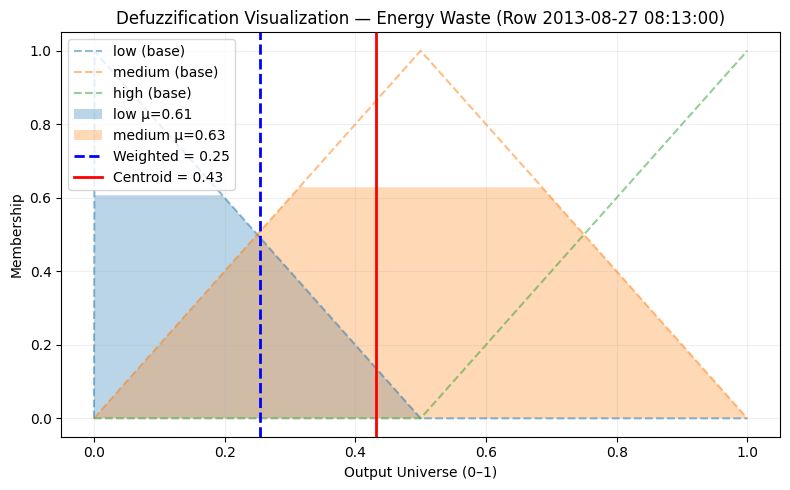

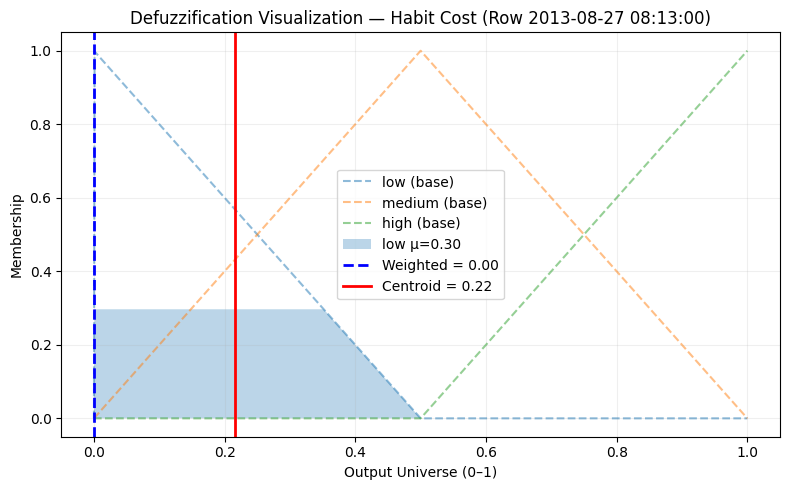

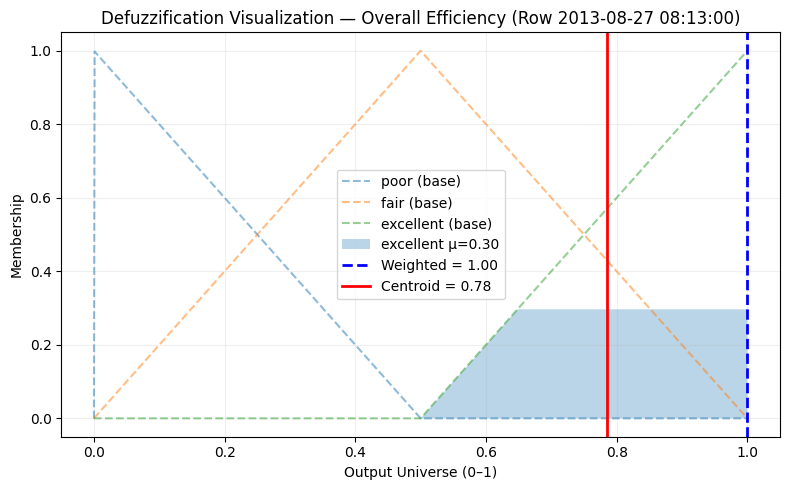

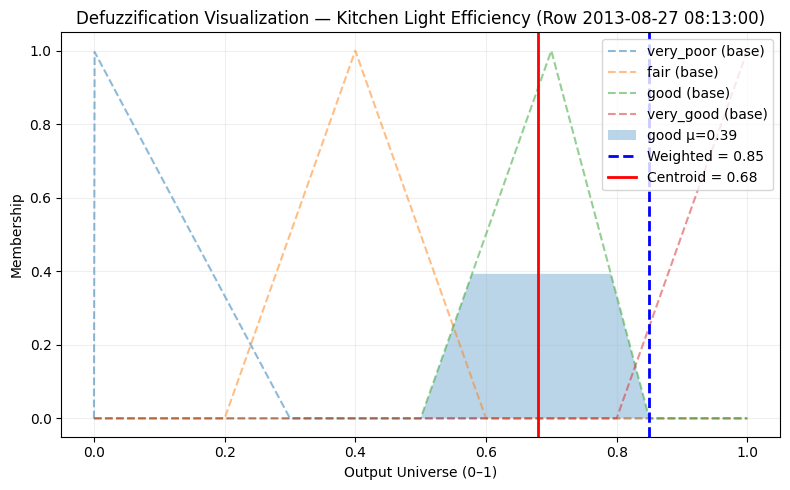

In [15]:
# --- choose your row ---
# (assumes row_idx is already set, or replace with a number or timestamp)
if not isinstance(row_idx, (int, np.integer)):
    row_pos = fuzzy_rules_fn.index.get_loc(row_idx)
else:
    row_pos = row_idx

row = fuzzy_rules_fn.iloc[row_pos]

# --- loop through your fuzzy outputs ---
for out_name, cols in COL_MAP.items():

    # Get membership degrees for this row (already computed)
    degrees = {c.split('_')[-1]: float(row[c]) for c in cols}
    shapes = OUTPUT_SHAPES[out_name]  # base triangles

    # Get already computed crisp values
    centroid_col = f"{out_name}_centroid"
    weighted_col = f"{out_name}_score"

    centroid = centroid_scores.iloc[row_pos][centroid_col] if centroid_col in centroid_scores.columns else np.nan
    weighted = scores_df.iloc[row_pos][weighted_col] if weighted_col in scores_df.columns else np.nan

    # --- plot ---
    plt.figure(figsize=(8, 5))

    # Base triangle curves
    for label, base in shapes.items():
        plt.plot(U, base, '--', alpha=0.5, label=f'{label} (base)')

    # Shaded membership (clip visualization only)
    for label, base in shapes.items():
        mu = degrees.get(label, 0)
        if mu > 0:
            plt.fill_between(U, 0, np.minimum(base, mu), alpha=0.3, label=f'{label} μ={mu:.2f}')

    # Draw defuzzified crisp outputs (already computed)
    if not np.isnan(weighted):
        plt.axvline(weighted, color='blue', lw=2, linestyle='--', label=f'Weighted = {weighted:.2f}')
    if not np.isnan(centroid):
        plt.axvline(centroid, color='red', lw=2, label=f'Centroid = {centroid:.2f}')

    plt.title(f'Defuzzification Visualization — {out_name.replace("_"," ").title()} (Row {row_idx})')
    plt.xlabel('Output Universe (0–1)')
    plt.ylabel('Membership')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


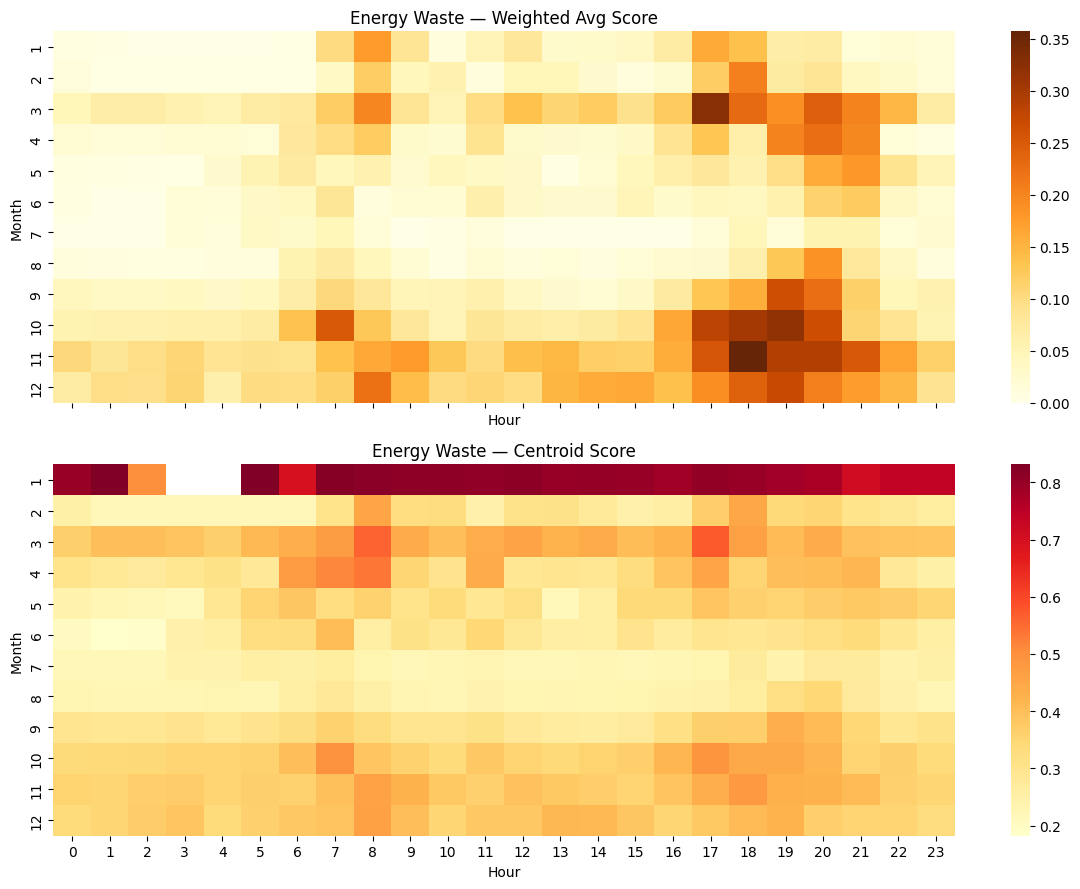

In [16]:
# Ensure both sets have hour/month
df_compare = pd.DataFrame({
    'month': fuzzy_data['month'],
    'hour': fuzzy_data['hour'],
    'weighted': scores_df['energy_waste_score'],
    'centroid': centroid_scores['energy_waste_centroid'],
})

pivot_w = df_compare.pivot_table(values='weighted', index='month', columns='hour')
pivot_c = df_compare.pivot_table(values='centroid', index='month', columns='hour')

fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
sns.heatmap(pivot_w, ax=axes[0], cmap='YlOrBr', cbar=True)
axes[0].set_title('Energy Waste — Weighted Avg Score')
sns.heatmap(pivot_c, ax=axes[1], cmap='YlOrRd', cbar=True)
axes[1].set_title('Energy Waste — Centroid Score')
for ax in axes:
    ax.set_ylabel('Month')
    ax.set_xlabel('Hour')
plt.tight_layout()
plt.show()


# 5. Visualize defuzzified scores

We’ll compare weighted-average vs centroid scores over time and by hour-of-day:
- Time series (daily mean) for Energy Waste, Habit Cost, Overall Efficiency, and Kitchen Light Efficiency.
- Hour-of-day bar chart comparing Energy Waste (weighted vs centroid).
- Distribution of waste_cost_priority to highlight the worst hours.

## 5.1. Single-day centroid analysis

This section restricts centroid defuzzification to a single day so you can inspect one date without aggregating the whole month.

How to use:
- Set `target_date` to a YYYY-MM-DD string (preferred), or
- Leave `target_date=None` and set `target_day` to a day-of-month integer.

Outputs:
- `centroid_scores_day`: centroid scores for the selected day.
- A quick by-hour plot for Energy Waste (centroid) on that day, and optional comparison with weighted-average if present.

In [17]:
# Compute centroid scores for a single day

# 1) Choose a day (either set target_date as a string, or use target_day as integer fallback)
# Preferred: use a concrete date present in your index (YYYY-MM-DD)
# Example: target_date = '2013-01-02'
target_date = None  # set to a date string like '2013-01-02' to use datetime filtering
target_day = 2      # fallback day-of-month if target_date is None (change as needed)

# 2) Ensure prerequisites exist
try:
    _ = fuzzy_rules_fn.head(1)
except NameError:
    fuzzy_rules_fn = compute_mamdani_rules(fuzzy_data)

# Ensure centroid definitions exist (U, OUTPUT_SHAPES, COL_MAP, _centroid_from_degrees)
try:
    _ = OUTPUT_SHAPES['energy_waste']
except Exception:
    # Rebuild minimal centroid definitions if user executed cells out of order
    U = np.linspace(0.0, 1.0, 1001)
    def _tri(a,b,c):
        return triangular_membership(U, a, b, c)
    OUTPUT_SHAPES = {
        'energy_waste': {
            'low': _tri(0.0, 0.0, 0.5),
            'medium': _tri(0.0, 0.5, 1.0),
            'high': _tri(0.5, 1.0, 1.0),
        },
        'habit_cost': {
            'low': _tri(0.0, 0.0, 0.5),
            'medium': _tri(0.0, 0.5, 1.0),
            'high': _tri(0.5, 1.0, 1.0),
        },
        'overall_efficiency': {
            'poor': _tri(0.0, 0.0, 0.5),
            'fair': _tri(0.0, 0.5, 1.0),
            'excellent': _tri(0.5, 1.0, 1.0),
        },
        'kitchen_light_efficiency': {
            'very_poor': _tri(0.0, 0.0, 0.3),
            'fair': _tri(0.2, 0.4, 0.6),
            'good': _tri(0.5, 0.7, 0.85),
            'very_good': _tri(0.8, 1.0, 1.0),
        },
    }
    COL_MAP = {
        'energy_waste': ['energy_waste_low','energy_waste_medium','energy_waste_high'],
        'habit_cost': ['habit_cost_low','habit_cost_medium','habit_cost_high'],
        'overall_efficiency': ['overall_efficiency_poor','overall_efficiency_fair','overall_efficiency_excellent'],
        'kitchen_light_efficiency': [
            'kitchen_light_efficiency_very_poor',
            'kitchen_light_efficiency_fair',
            'kitchen_light_efficiency_good',
            'kitchen_light_efficiency_very_good',
        ],
    }
    def _centroid_from_degrees(label_shapes: dict, degrees: dict) -> float:
        if not degrees:
            return np.nan
        clipped = []
        for lab, shape in label_shapes.items():
            mu = float(degrees.get(lab, 0.0))
            if mu <= 0:
                continue
            clipped.append(np.minimum(shape, mu))
        if not clipped:
            return np.nan
        agg = np.maximum.reduce(clipped)
        den = np.trapezoid(agg, U)
        if den <= 1e-12:
            return np.nan
        num = np.trapezoid(U * agg, U)
        return float(num / den)

# 3) Build mask for selected day
if isinstance(fuzzy_rules_fn.index, pd.DatetimeIndex) and (target_date is not None):
    day_start = pd.to_datetime(target_date).normalize()
    day_end = day_start + pd.Timedelta(days=1)
    mask = (fuzzy_rules_fn.index >= day_start) & (fuzzy_rules_fn.index < day_end)
elif (target_date is None) and (target_day is not None) and ('day' in fuzzy_data.columns):
    # Use day-of-month column fallback
    mask = (fuzzy_data['day'] == target_day)
else:
    # If nothing specified, pick the first calendar day in the index
    if isinstance(fuzzy_rules_fn.index, pd.DatetimeIndex):
        first_day = fuzzy_rules_fn.index.normalize()[0]
        day_start = first_day
        day_end = day_start + pd.Timedelta(days=1)
        mask = (fuzzy_rules_fn.index >= day_start) & (fuzzy_rules_fn.index < day_end)
        print(f"No target_date/target_day provided; defaulting to {day_start.date()}.")
    else:
        if 'day' in fuzzy_data.columns:
            mode_day = int(fuzzy_data['day'].mode().iloc[0])
            mask = (fuzzy_data['day'] == mode_day)
            print(f"No date index; defaulting to day-of-month == {mode_day}.")
        else:
            raise ValueError("Cannot determine a single day: provide target_date or target_day.")

subset_idx = fuzzy_rules_fn.index[mask]
subset_rules = fuzzy_rules_fn.loc[subset_idx]

if subset_rules.empty:
    raise ValueError("Selected day has no rows. Adjust target_date/target_day.")

# 4) Compute centroid scores for the subset only
centroid_scores_day = pd.DataFrame(index=subset_rules.index)
for out_name, cols in COL_MAP.items():
    present = [c for c in cols if c in subset_rules.columns]
    if not present:
        centroid_scores_day[f'{out_name}_centroid'] = np.nan
        continue
    shapes = OUTPUT_SHAPES[out_name]
    vals = []
    for idx, row in subset_rules[present].iterrows():
        deg = {c.split('_')[-1]: float(row[c]) for c in present}
        vals.append(_centroid_from_degrees(shapes, deg))
    centroid_scores_day[f'{out_name}_centroid'] = vals

# Attach hour/day/month for grouping if available
for col in ['hour','day','month']:
    if col in fuzzy_data.columns:
        centroid_scores_day[col] = fuzzy_data.loc[subset_idx, col]

# 5) Preview and quick per-hour view
display(centroid_scores_day.head())
if 'hour' in centroid_scores_day.columns:
    per_month_hour = centroid_scores_day.groupby('hour')[[
        'energy_waste_centroid','habit_cost_centroid','overall_efficiency_centroid'
    ]].mean().round(3)
    display(per_month_hour)

print('Single-day centroid computation complete.')

,energy_waste_centroid,habit_cost_centroid,overall_efficiency_centroid,kitchen_light_efficiency_centroid,hour,day,month
timestamp,,,,,,,
2013-01-02 00:00:00,NaN,0.223504,NaN,NaN,0,2,1
2013-01-02 00:01:00,NaN,0.223504,NaN,NaN,0,2,1
2013-01-02 00:02:00,NaN,0.223504,NaN,NaN,0,2,1
2013-01-02 00:03:00,NaN,0.223504,NaN,NaN,0,2,1
2013-01-02 00:04:00,NaN,0.223504,NaN,NaN,0,2,1


,energy_waste_centroid,habit_cost_centroid,overall_efficiency_centroid
hour,,,
0,0.254,0.210,0.779
1,0.210,0.207,0.781
2,0.221,0.204,0.773
3,0.213,0.210,0.778
4,0.210,0.210,0.780
5,0.208,0.213,0.780
6,0.236,0.240,0.777
7,0.369,0.271,0.767
8,0.292,0.286,0.774


Single-day centroid computation complete.


## 5.2. Centroid-only overview: Energy Waste, Habit Cost, Overall Efficiency (selected day)

One figure with three panels showing centroid scores by hour for the selected day.


Centroid-only overview figure complete (row-wise, hours 1-24, all panels show ticks).


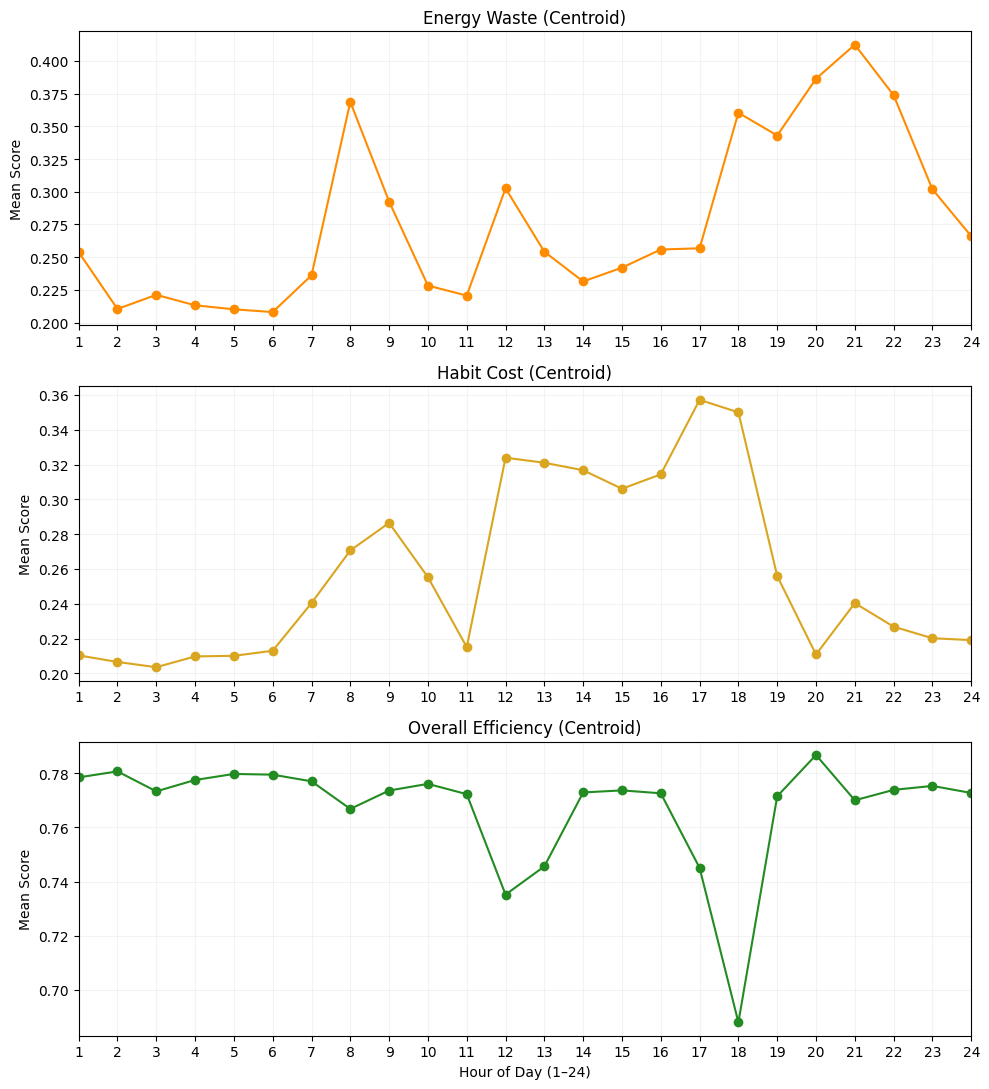

In [18]:
# Centroid-only overview figure (row-wise layout, hours shown as 1-24 with ticks on all panels)

per_hour = centroid_scores_day.groupby('hour').mean(numeric_only=True).reset_index()
# Convert 0-23 to 1-24 for display
display_hrs = per_hour['hour'] + 1

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 11), sharex=True)

# Energy Waste
ax = axes[0]
ax.plot(display_hrs, per_hour['energy_waste_centroid'], marker='o', color='darkorange')
ax.set_title('Energy Waste (Centroid)')
ax.set_ylabel('Mean Score')
ax.grid(alpha=0.15)

# Habit Cost
ax = axes[1]
ax.plot(display_hrs, per_hour['habit_cost_centroid'], marker='o', color='goldenrod')
ax.set_title('Habit Cost (Centroid)')
ax.set_ylabel('Mean Score')
ax.grid(alpha=0.15)

# Overall Efficiency
ax = axes[2]
ax.plot(display_hrs, per_hour['overall_efficiency_centroid'], marker='o', color='forestgreen')
ax.set_title('Overall Efficiency (Centroid)')
ax.set_xlabel('Hour of Day (1–24)')
ax.set_ylabel('Mean Score')
ax.grid(alpha=0.15)

# Set x ticks to 1..24 and force tick labels on all shared x-axes
for ax in axes:
    ax.set_xticks(range(1,25))
    ax.set_xlim(1,24)
    ax.tick_params(axis='x', which='both', labelbottom=True)

plt.tight_layout()
print('Centroid-only overview figure complete (row-wise, hours 1-24, all panels show ticks).')

Heatmap that shows results per hour for each month of the year:

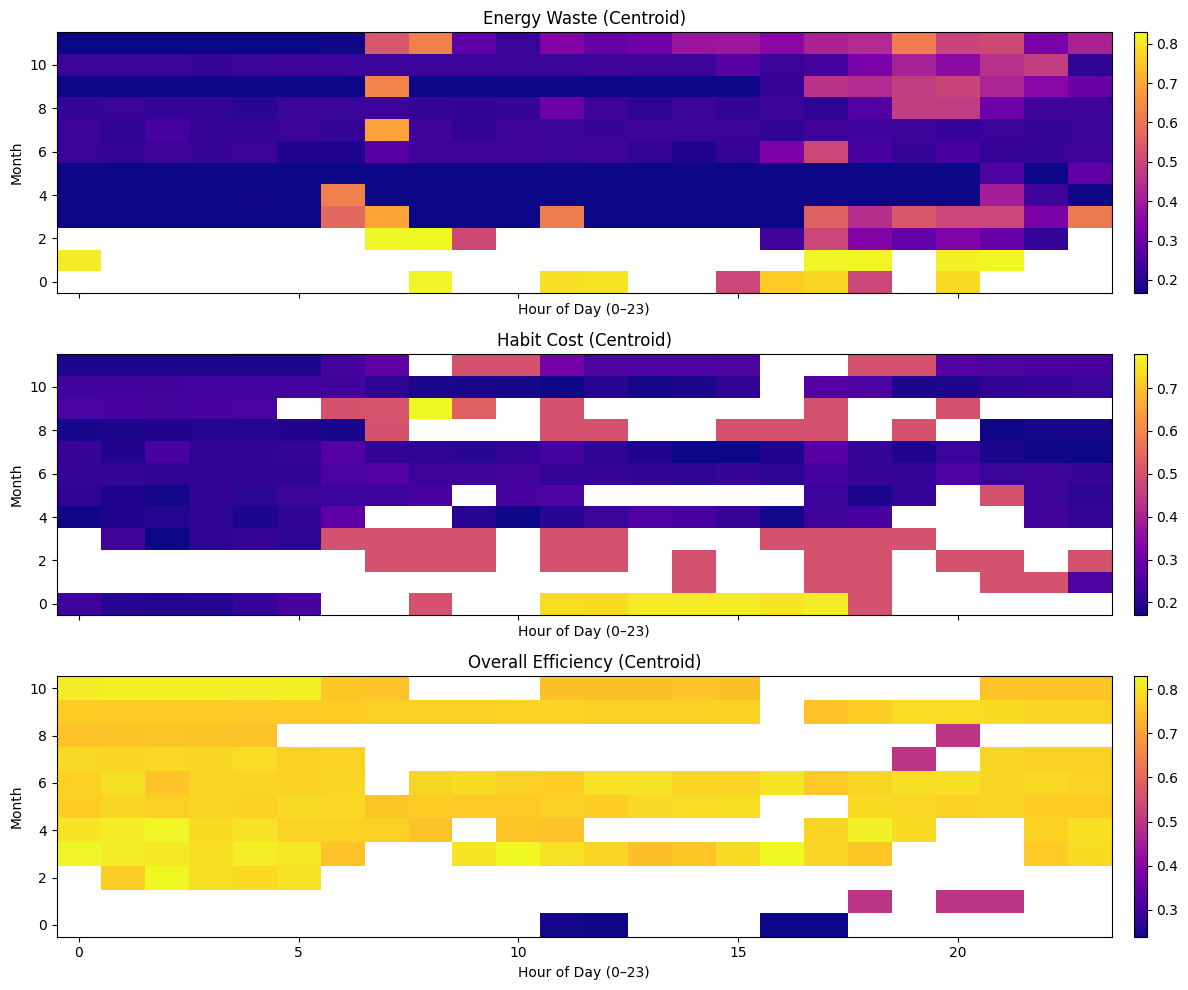

In [19]:
# --- Group by month and hour ---
per_month_hour = (
    centroid_scores_day
    .groupby(['month', 'hour'])
    [['energy_waste_centroid', 'habit_cost_centroid', 'overall_efficiency_centroid']]
    .mean(numeric_only=True)
    .reset_index()
)

# Pivot to month × hour grids
heatmaps = {
    'Energy Waste (Centroid)': per_month_hour.pivot_table(values='energy_waste_centroid', index='month', columns='hour'),
    'Habit Cost (Centroid)': per_month_hour.pivot_table(values='habit_cost_centroid', index='month', columns='hour'),
    'Overall Efficiency (Centroid)': per_month_hour.pivot_table(values='overall_efficiency_centroid', index='month', columns='hour'),
}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

for ax, (title, data) in zip(axes, heatmaps.items()):
    im = ax.imshow(data, aspect='auto', cmap='plasma', origin='lower')
    ax.set_title(title)
    ax.set_ylabel('Month')
    ax.set_xlabel('Hour of Day (0–23)')
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)

plt.tight_layout()
plt.show()


## 5.3. Combined weighted vs centroid comparison (Energy Waste, Habit Cost, Overall Efficiency)

Single figure comparing centroid (shape-sensitive) and weighted (label-average) scores by hour for the selected day across the three key outputs.

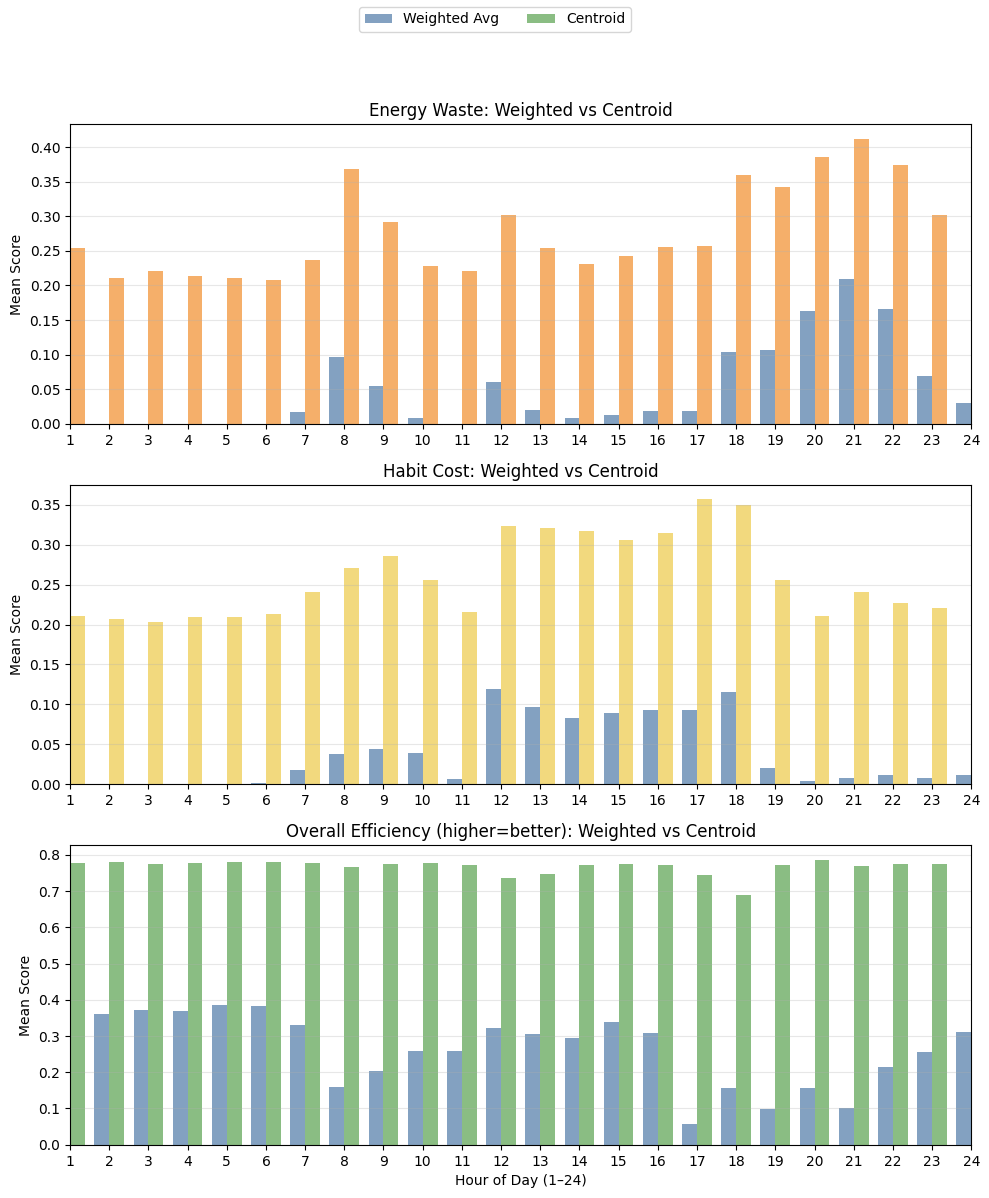

Combined weighted vs centroid comparison complete (row-wise, hours 1-24).


In [20]:
# Weighted vs Centroid comparison for all three outputs (by hour) — row-wise layout with hours 1–24

# Preconditions
if 'centroid_scores_day' not in globals() or centroid_scores_day.empty:
    raise RuntimeError("centroid_scores_day is missing or empty. Run the single-day centroid cell above first.")

if 'hour' not in centroid_scores_day.columns:
    raise RuntimeError("centroid_scores_day must contain an 'hour' column for grouping.")

if 'scores_df' not in globals() or scores_df.empty:
    raise RuntimeError("scores_df (weighted scores) is missing or empty. Run the weighted defuzz cell above first.")

# Helper to compute hourly means for a centroid+weighted pair

def _hourly_pair(centroid_col, weighted_col):
    shared = centroid_scores_day.index.intersection(scores_df.index)
    if shared.empty:
        # Fall back to centroid-only; return centroid with no weighted
        tmp = pd.DataFrame({
            'hour': centroid_scores_day['hour'],
            'centroid': centroid_scores_day[centroid_col]
        })
        return tmp.groupby('hour').mean()

    tmp = pd.DataFrame({
        'hour': centroid_scores_day.loc[shared, 'hour'],
        'centroid': centroid_scores_day.loc[shared, centroid_col],
        'weighted': scores_df.loc[shared, weighted_col]
    })
    return tmp.groupby('hour').mean()

pairs = [
    ('energy_waste_centroid', 'energy_waste_score', 'Energy Waste', '#f28e2b'),
    ('habit_cost_centroid', 'habit_cost_score', 'Habit Cost', '#edc948'),
    ('overall_efficiency_centroid', 'overall_efficiency_score', 'Overall Efficiency (higher=better)', '#59a14f'),
]

# Row-wise layout with shared x-axis (hours 1–24)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)
width = 0.38

for ax, (c_col, w_col, title, c_color) in zip(axes, pairs):
    df = _hourly_pair(c_col, w_col)
    hrs = df.index.values
    hrs1 = hrs + 1  # shift to 1..24 for display
    if 'weighted' in df.columns:
        ax.bar(hrs1 - width/2, df['weighted'], width=width, label='Weighted Avg', alpha=0.7, color='#4e79a7')
        ax.bar(hrs1 + width/2, df['centroid'], width=width, label='Centroid', alpha=0.7, color=c_color)
    else:
        ax.bar(hrs1, df['centroid'], width=0.6, label='Centroid', alpha=0.8, color=c_color)
    ax.set_title(f'{title}: Weighted vs Centroid')
    ax.set_ylabel('Mean Score')
    ax.grid(alpha=0.3, axis='y')

# X-axis formatting (shared across all panels)
axes[-1].set_xlabel('Hour of Day (1–24)')
for ax in axes:
    ax.set_xticks(range(1, 25))
    ax.set_xlim(1, 24)
    ax.tick_params(axis='x', which='both', labelbottom=True)

# Shared legend on top
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)
fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

print('Combined weighted vs centroid comparison complete (row-wise, hours 1-24).')

## 6. Validation method to check the system works the way it should.

6.1 Performs a sensitivity analysis on the fuzzy logic system by slightly increasing and decreasing the main input columns - like lights, activity by 10%. For each adjustments, it calculated the fuzzy memberships, applies the fuzzy rules and compute the final score and centroids and then compares the result with the original result - to check how the system changes. The main objective is to find whether the system is stable or sensitive to changes. If the output changes a little, then the system is robust or else it is sensitive to changes.

In [21]:
print("Current columns in data:")
print(list(data.columns))

Current columns in data:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [22]:
# 1. Load data with proper headers
file_path = "data/house1_clean_with_elprices.csv"
data = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")

# 2. Categories
data.attrs["categories"] = {
    "kitchen_activity": ["breadmaker", "coffee_machine", "dishwasher", "fridge", "gas_oven", "kettle", "kitchen_phone&stereo", "kitchen_radio", "microwave", "toaster"],
    "kitchen_lights": ["kitchen_lights", "kitchen_dt_lamp", "kitchen_lamp2"],
    "lounge_activity": ["amp_livingroom", "DAB_radio_livingroom", "htpc", "iPad_charger","subwoofer_livingroom", "tv"],
    "lounge_lights": ["livingroom_s_lamp", "livingroom_s_lamp2", "livingroom_lamp_tv"]
}

# 3. Aggregate categories
for category_name, appliance_list in data.attrs["categories"].items():
    data[category_name] = data[appliance_list].sum(axis=1)

# 4. Keep only the columns we need
columns_to_keep = [
    "kitchen_lights",
    "kitchen_activity",
    "lounge_activity",
    "lounge_lights",
    "spot_price",
    "hour",
    "month",
    "day"
]

data = data[columns_to_keep]

print(data.columns.tolist())


['kitchen_lights', 'kitchen_activity', 'lounge_activity', 'lounge_lights', 'spot_price', 'hour', 'month', 'day']


Using raw source: data. Perturbing columns: ['kitchen_lights', 'lounge_lights', 'kitchen_activity', 'lounge_activity', 'spot_price']. Raw base cols subset: ['kitchen_lights', 'kitchen_activity', 'lounge_activity', 'lounge_lights', 'spot_price', 'hour', 'month', 'day']
Sensitivity Summary (Mean Absolute Change):


factor,0.9,1.1
metric,,
Δ|energy_waste_centroid|,0.1020,0.0850
Δ|energy_waste_score|,0.0498,0.0446
Δ|habit_cost_centroid|,0.0095,0.0091
Δ|habit_cost_score|,0.0075,0.0092
Δ|kitchen_light_efficiency_centroid|,0.0001,0.0001
Δ|kitchen_light_efficiency_score|,0.2180,0.2196
Δ|overall_efficiency_centroid|,0.0305,0.0251
Δ|overall_efficiency_score|,0.2606,0.1968


Shared score cols: ['energy_waste_score', 'habit_cost_score', 'overall_efficiency_score', 'kitchen_light_efficiency_score']
Shared centroid cols: ['energy_waste_centroid', 'habit_cost_centroid', 'overall_efficiency_centroid', 'kitchen_light_efficiency_centroid']


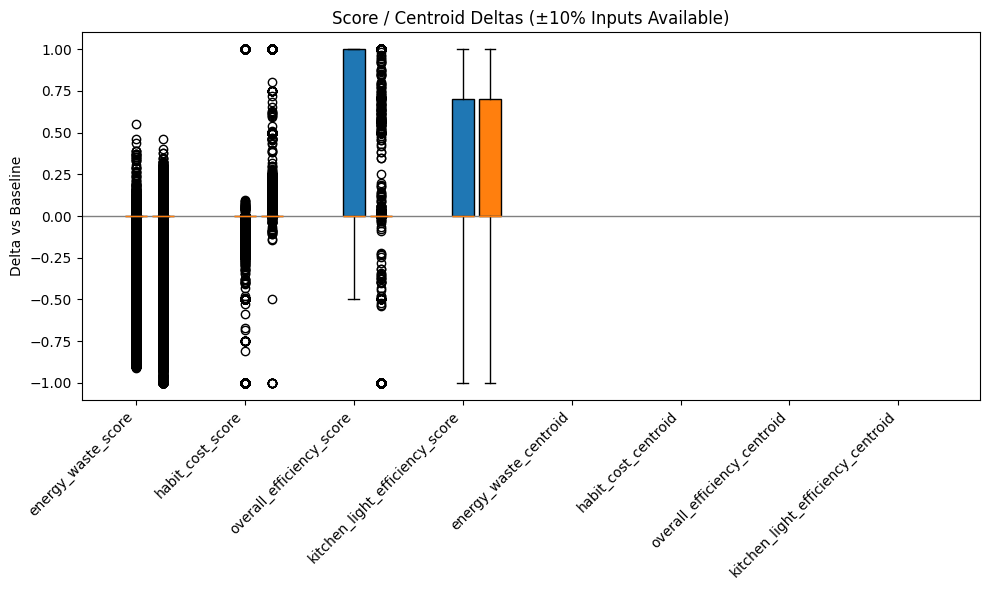

Bar chart of mean absolute change per metric:


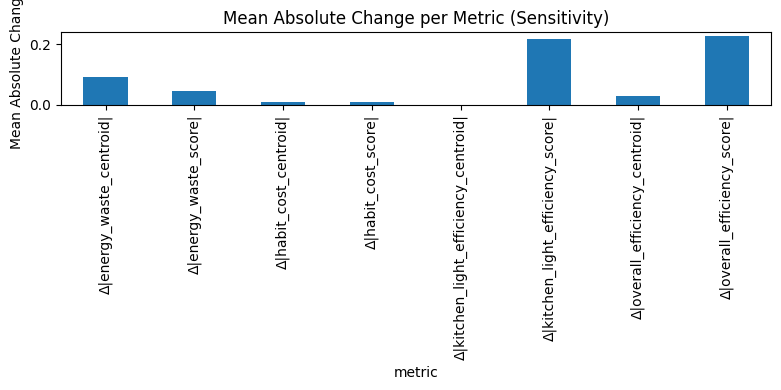

metric
Δ|energy_waste_centroid|                0.093487
Δ|energy_waste_score|                   0.047191
Δ|habit_cost_centroid|                  0.009324
Δ|habit_cost_score|                     0.008320
Δ|kitchen_light_efficiency_centroid|    0.000068
Δ|kitchen_light_efficiency_score|       0.218775
Δ|overall_efficiency_centroid|          0.027781
Δ|overall_efficiency_score|             0.228702
dtype: float64


In [23]:
# Sensitivity Analysis: ±10% Perturbations on Core Inputs (Aggregated Data Version)
# Uses the already aggregated 'data' DataFrame as the raw source.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RAW_REQUIRED_BASE = ['kitchen_lights','lounge_lights','kitchen_activity','lounge_activity','spot_price']
PERTURB_COLUMNS = [c for c in RAW_REQUIRED_BASE if c in data.columns]
FACTORS = [0.9, 1.1]

raw_source = data.copy()
source_name = 'data'

if not all(col in raw_source.columns for col in ['kitchen_lights', 'spot_price']):
    raise ValueError("The aggregated 'data' DataFrame must contain at least 'kitchen_lights' and 'spot_price'.")

if not PERTURB_COLUMNS:
    raise ValueError("No perturbable columns found in 'data'. Ensure aggregation created the required columns.")

for needed in ['fuzzy_rules_fn','scores_df','centroid_scores']:
    if needed not in globals():
        raise RuntimeError(f"Baseline object '{needed}' not found. Run prior computation cells first.")

baseline_scores = scores_df.copy()
baseline_centroids = centroid_scores.copy()

# Triangular membership helper

def _triangular_membership_vec(x, a, b, c):
    x = np.asarray(x, dtype=float)
    left = np.where((x >= a) & (x <= b), (x - a) / (b - a + 1e-12), 0.0)
    right = np.where((x >= b) & (x <= c), (c - x) / (c - b + 1e-12), 0.0)
    return np.maximum(left, right)

# Build fuzzified slice with only available raw drivers

def build_fuzzified(df_raw: pd.DataFrame) -> pd.DataFrame:
    out = df_raw.copy()
    if 'kitchen_lights' in out.columns:
        for label,(a,b,c) in lights_limits.items():
            out[f'kitchen_lights_{label}'] = _triangular_membership_vec(out['kitchen_lights'], a,b,c)
    if 'lounge_lights' in out.columns:
        for label,(a,b,c) in lights_limits.items():
            out[f'lounge_lights_{label}'] = _triangular_membership_vec(out['lounge_lights'], a,b,c)
    if 'kitchen_activity' in out.columns:
        for label,(a,b,c) in activity_limits.items():
            out[f'kitchen_activity_{label}'] = _triangular_membership_vec(out['kitchen_activity'], a,b,c)
    if 'lounge_activity' in out.columns:
        for label,(a,b,c) in activity_limits.items():
            out[f'lounge_activity_{label}'] = _triangular_membership_vec(out['lounge_activity'], a,b,c)
    if 'spot_price' in out.columns:
        for label,(a,b,c) in electricity_prices.items():
            out[f'spot_price_{label}'] = _triangular_membership_vec(out['spot_price'], a,b,c)
    if 'hour' in out.columns:
        for label,(a,b,c) in time_of_day.items():
            col = f'time_{label}'
            if col not in out.columns:
                out[col] = _triangular_membership_vec(out['hour'], a,b,c)
    return out

RAW_BASE_COLS = [c for c in raw_source.columns if c in RAW_REQUIRED_BASE or c in ['hour','day','month']]
print(f"Using raw source: {source_name}. Perturbing columns: {PERTURB_COLUMNS}. Raw base cols subset: {RAW_BASE_COLS}")

scenario_rows = []
scenario_deltas = []

for factor in FACTORS:
    pert_raw = raw_source[RAW_BASE_COLS].copy()
    for col in PERTURB_COLUMNS:
        pert_raw[col] = pert_raw[col] * factor
    pert_fuzzy = build_fuzzified(pert_raw)

    # Check that at least kitchen lights memberships exist
    if not any(c.startswith('kitchen_lights_') for c in pert_fuzzy.columns):
        raise ValueError("Kitchen lights memberships not generated; verify lights_limits and raw column scale.")

    pert_rules = compute_mamdani_rules(pert_fuzzy)

    # Weighted scores (handle potential missing columns gracefully)
    pert_scores = pd.DataFrame(index=pert_rules.index)
    pert_scores['energy_waste_score'] = _weighted_average_score(pert_rules, _waste_map)
    pert_scores['habit_cost_score'] = _weighted_average_score(pert_rules, _habit_map)
    pert_scores['overall_efficiency_score'] = _weighted_average_score(pert_rules, _overall_eff_map)
    pert_scores['kitchen_light_efficiency_score'] = _weighted_average_score(pert_rules, _kitchen_eff_map)

    # Centroids (skip outputs lacking memberships)
    pert_centroids = pd.DataFrame(index=pert_rules.index)
    for out_name, cols in COL_MAP.items():
        present = [c for c in cols if c in pert_rules.columns]
        if not present:
            pert_centroids[f'{out_name}_centroid'] = np.nan
            continue
        shapes = OUTPUT_SHAPES[out_name]
        vals = []
        for _, row_r in pert_rules[present].iterrows():
            deg = {c.split('_')[-1]: float(row_r[c]) for c in present}
            vals.append(_centroid_from_degrees(shapes, deg))
        pert_centroids[f'{out_name}_centroid'] = vals

    shared_score_cols = [c for c in baseline_scores.columns if c in pert_scores.columns]
    shared_centroid_cols = [c for c in baseline_centroids.columns if c in pert_centroids.columns]

    delta_scores = pert_scores[shared_score_cols] - baseline_scores[shared_score_cols]
    delta_centroids = pert_centroids[shared_centroid_cols] - baseline_centroids[shared_centroid_cols]

    summary_scores = delta_scores.abs().mean().rename(lambda x: f"Δ|{x}|")
    summary_centroids = delta_centroids.abs().mean().rename(lambda x: f"Δ|{x}|")
    summary_df = pd.concat([summary_scores, summary_centroids])

    scenario_rows.append(pd.DataFrame({
        'factor': factor,
        'metric': summary_df.index,
        'mean_abs_change': summary_df.values
    }))

    dscores_long = delta_scores.melt(ignore_index=False, var_name='metric', value_name='delta')
    dscores_long['factor'] = factor
    dcentroids_long = delta_centroids.melt(ignore_index=False, var_name='metric', value_name='delta')
    dcentroids_long['factor'] = factor
    scenario_deltas.append(pd.concat([dscores_long, dcentroids_long]))

summary_all = pd.concat(scenario_rows, ignore_index=True)
deltas_all = pd.concat(scenario_deltas, ignore_index=False)

print("Sensitivity Summary (Mean Absolute Change):")
if not summary_all.empty:
    display(summary_all.pivot(index='metric', columns='factor', values='mean_abs_change').round(4))
else:
    print("No summary rows (possibly no overlapping metrics).")
    display(pd.DataFrame({'info':['No metrics']}))  # Always show something

print("Shared score cols:", shared_score_cols)
print("Shared centroid cols:", shared_centroid_cols)

# Plotting with guards and fallback
plotted_any = False
plt.figure(figsize=(10,6))
for i, factor in enumerate(FACTORS, 1):
    subset = deltas_all[deltas_all['factor'] == factor]
    metrics = subset['metric'].unique()
    if len(metrics) == 0:
        print(f"No metrics to plot for factor {factor}.")
        continue
    positions = np.arange(len(metrics)) + (i-1)*0.25
    data_to_plot = [subset[subset['metric']==m]['delta'] for m in metrics]
    if all(len(d)==0 for d in data_to_plot):
        print(f"Empty delta series for factor {factor}.")
        continue
    bp = plt.boxplot(data_to_plot, positions=positions, widths=0.2, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('#1f77b4' if factor < 1 else '#ff7f0e')
    plotted_any = True

if plotted_any:
    plt.xticks(np.arange(len(metrics)), metrics, rotation=45, ha='right')
    plt.axhline(0, color='gray', lw=1)
    plt.title('Score / Centroid Deltas (±10% Inputs Available)')
    plt.ylabel('Delta vs Baseline')
    plt.tight_layout()
    plt.show()
else:
    print("Fallback: no boxplots produced. Attempting mean delta bar chart.")
    if not deltas_all.empty:
        means = deltas_all.groupby('metric')['delta'].mean()
        if not means.empty:
            plt.figure(figsize=(8,4))
            means.plot(kind='bar', title='Mean Delta per Metric')
            plt.axhline(0, color='gray', lw=1)
            plt.ylabel('Mean Delta')
            plt.tight_layout()
            plt.show()
        else:
            print("No mean deltas to visualize.")
            display(pd.DataFrame({'info':['No mean deltas']}))
    else:
        print("No delta data at all.")
        display(pd.DataFrame({'info':['No delta data']}))

# Always print and plot summary as bar chart
if not summary_all.empty:
    print("Bar chart of mean absolute change per metric:")
    summary_bar = summary_all.pivot(index='metric', columns='factor', values='mean_abs_change').mean(axis=1)
    summary_bar.plot(kind='bar', figsize=(8,4), title='Mean Absolute Change per Metric (Sensitivity)')
    plt.ylabel('Mean Absolute Change')
    plt.tight_layout()
    plt.show()
    print(summary_bar)
else:
    print("No summary data to plot.")

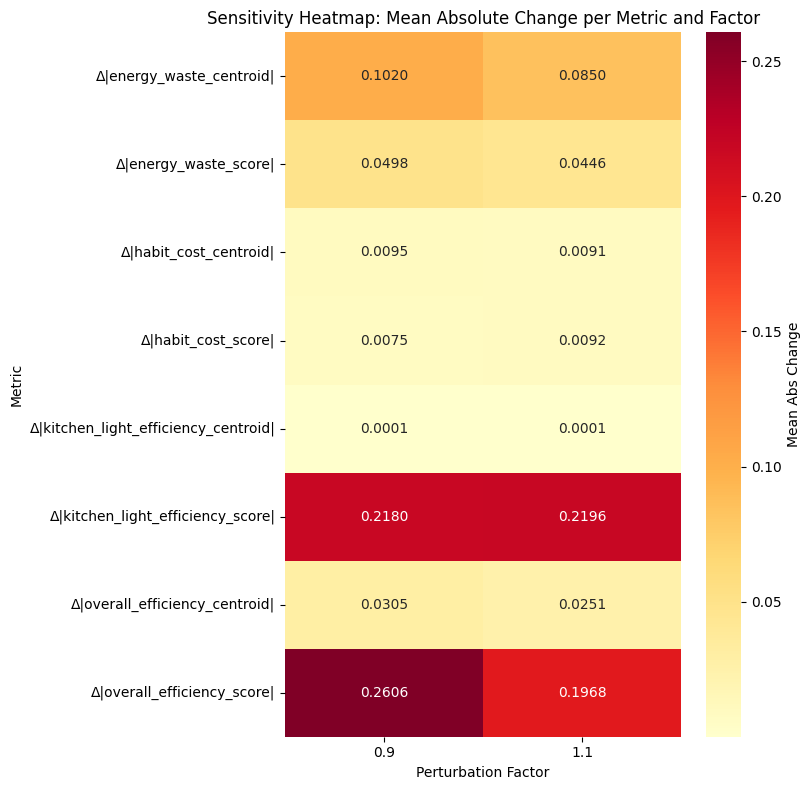

In [24]:
# Heatmap of Sensitivity Intensities
# Visualizes the mean absolute change per metric and per factor as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

if not summary_all.empty:
    # Pivot to metric × factor grid
    heatmap_data = summary_all.pivot(index='metric', columns='factor', values='mean_abs_change')
    plt.figure(figsize=(8, max(4, len(heatmap_data))))
    ax = sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'Mean Abs Change'})
    ax.set_title('Sensitivity Heatmap: Mean Absolute Change per Metric and Factor')
    ax.set_xlabel('Perturbation Factor')
    ax.set_ylabel('Metric')
    plt.tight_layout()
    plt.show()
else:
    print("No sensitivity summary data available for heatmap.")


 ## 6.2. Compare FIS outputs against raw data to confirm that the fuzzy reasoning reflect real usage patterns.

In [25]:
# Validation: Compare FIS outputs against raw data

# Build a validation DataFrame
validation_df = pd.DataFrame({
    # Kitchen
    "kitchen_lights_raw": data["kitchen_lights"],
    "kitchen_activity_raw": data["kitchen_activity"],
    "kitchen_waste_fuzzy": fuzzy_rules_fn["kitchen_energy_waste_high"],

    # Lounge
    "lounge_lights_raw": data["lounge_lights"],
    "lounge_activity_raw": data["lounge_activity"],
    "lounge_waste_fuzzy": fuzzy_rules_fn["lounge_energy_waste_high"],

    # Cost-related
    "price_raw": data["spot_price"],
    "activity_total_raw": data["kitchen_activity"] + data["lounge_activity"],
    "habit_cost_fuzzy": scores_df["habit_cost_score"],

    # Aggregated fuzzy waste score (for time-series)
    "energy_waste_score": scores_df["energy_waste_score"]
})


In [26]:
# Correlation overview
corr = validation_df.corr().round(3)
display(corr)


,kitchen_lights_raw,kitchen_activity_raw,kitchen_waste_fuzzy,lounge_lights_raw,lounge_activity_raw,lounge_waste_fuzzy,price_raw,activity_total_raw,habit_cost_fuzzy,energy_waste_score
kitchen_lights_raw,1.000,0.158,0.565,0.088,0.019,-0.000,0.153,0.158,0.179,0.483
kitchen_activity_raw,0.158,1.000,-0.042,-0.001,0.014,-0.000,0.007,0.978,0.382,-0.074
kitchen_waste_fuzzy,0.565,-0.042,1.000,0.016,-0.000,-0.000,0.104,-0.041,0.008,0.658
lounge_lights_raw,0.088,-0.001,0.016,1.000,0.431,0.079,-0.018,0.090,-0.014,0.396
lounge_activity_raw,0.019,0.014,-0.000,0.431,1.000,0.001,0.014,0.223,0.007,0.144
lounge_waste_fuzzy,-0.000,-0.000,-0.000,0.079,0.001,1.000,0.001,-0.000,-0.000,0.007
price_raw,0.153,0.007,0.104,-0.018,0.014,0.001,1.000,0.010,0.235,0.063
activity_total_raw,0.158,0.978,-0.041,0.090,0.223,-0.000,0.010,1.000,0.374,-0.041
habit_cost_fuzzy,0.179,0.382,0.008,-0.014,0.007,-0.000,0.235,0.374,1.000,-0.025
energy_waste_score,0.483,-0.074,0.658,0.396,0.144,0.007,0.063,-0.041,-0.025,1.000


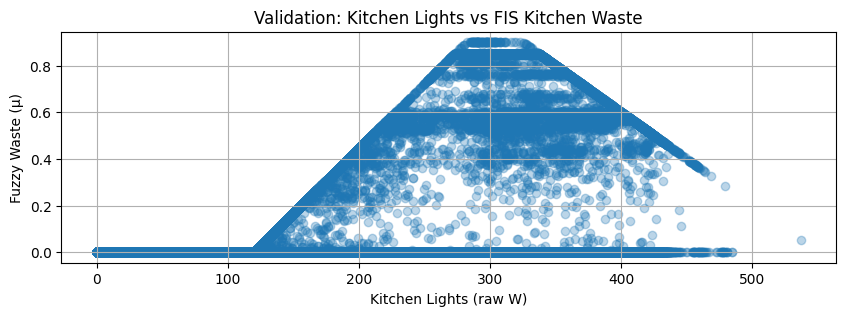

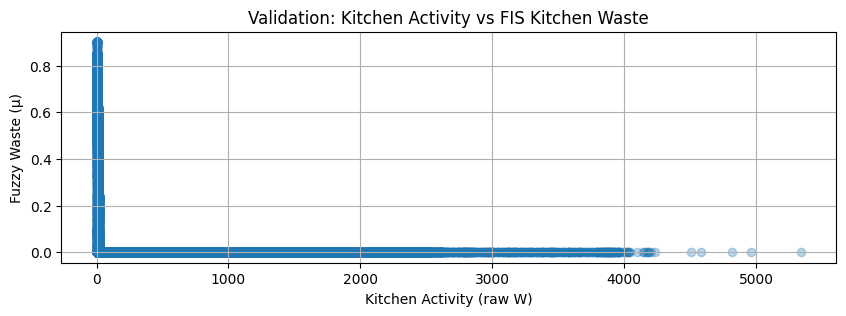

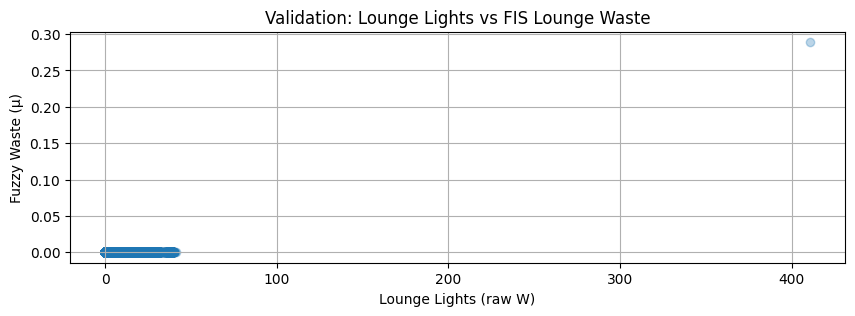

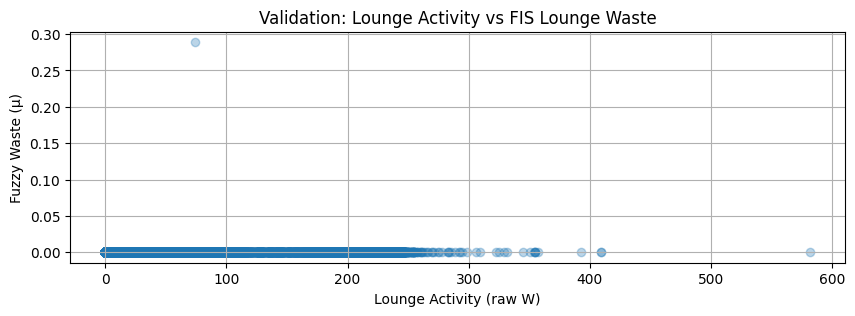

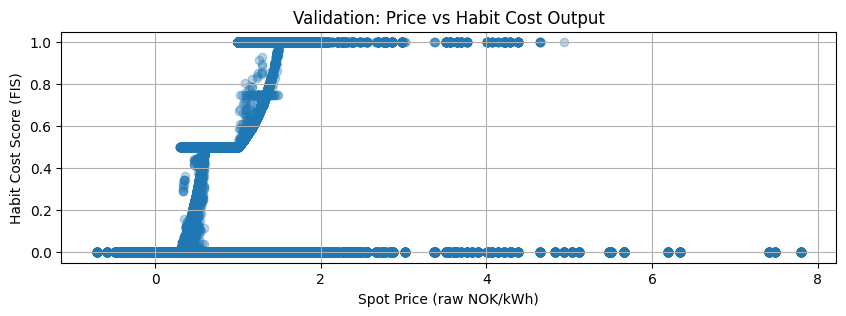

In [27]:
plots = [
    # --- KITCHEN VALIDATION ---
    ("kitchen_lights_raw", "kitchen_waste_fuzzy",
     "Kitchen Lights (raw W)", "Fuzzy Waste (μ)",
     "Validation: Kitchen Lights vs FIS Kitchen Waste"),

    ("kitchen_activity_raw", "kitchen_waste_fuzzy",
     "Kitchen Activity (raw W)", "Fuzzy Waste (μ)",
     "Validation: Kitchen Activity vs FIS Kitchen Waste"),

    # --- LOUNGE VALIDATION ---
    ("lounge_lights_raw", "lounge_waste_fuzzy",
     "Lounge Lights (raw W)", "Fuzzy Waste (μ)",
     "Validation: Lounge Lights vs FIS Lounge Waste"),

    ("lounge_activity_raw", "lounge_waste_fuzzy",
     "Lounge Activity (raw W)", "Fuzzy Waste (μ)",
     "Validation: Lounge Activity vs FIS Lounge Waste"),

    # --- HABIT COST VALIDATION ---
    ("price_raw", "habit_cost_fuzzy",
     "Spot Price (raw NOK/kWh)", "Habit Cost Score (FIS)",
     "Validation: Price vs Habit Cost Output"),
]

for x, y, xlab, ylab, title in plots:
    plt.figure(figsize=(10,3))
    plt.scatter(validation_df[x], validation_df[y], alpha=0.3)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.grid(True)
    plt.show()


1. Kitchen Lights vs FIS Kitchen Waste plot shows how kitchen lighting power relates to the fuzzy kitchen-waste output. Higher light usage during low kitchen activity results in higher waste scores, forming the triangular pattern defined by the FIS rules.

2. Kitchen Activity vs FIS Kitchen Waste validates that kitchen waste is only high when lights are on and activity is low. High activity correctly produces a near-zero waste score, even when activity power spikes.

3. Lounge Lights vs FIS Lounge Waste scatterplot shows that lounge waste increases only when lounge lights are on while lounge activity is low. Most points stay near zero because lounge lights are usually off or low.

4. Lounge Activity vs FIS Lounge Waste confirms that lounge waste only increases when lights are on while lounge activity is low or idle. High activity correctly produces near-zero waste even when activity power varies.

5. Price vs FIS Habit Cost figure shows how the FIS habit-cost score rises when electricity prices are high and household activity is high. The steep increase reflects the fuzzy rule weighting price × usage.

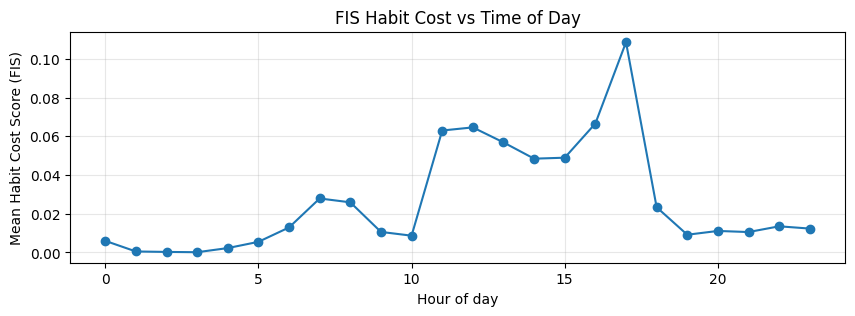

In [28]:
# Average fuzzy habit cost by hour of day
hourly = validation_df.copy()
hourly["hour"] = fuzzy_data["hour"]
hourly_mean = hourly.groupby("hour")["habit_cost_fuzzy"].mean()

plt.figure(figsize=(10,3))
plt.plot(hourly_mean.index, hourly_mean.values, marker="o")
plt.xlabel("Hour of day")
plt.ylabel("Mean Habit Cost Score (FIS)")
plt.title("FIS Habit Cost vs Time of Day")
plt.grid(True, alpha=0.3)
plt.show()


6. The FIS Habit Cost vs Time of Day plot shows how habit-cost scores vary across the day, with higher values occurring during hours where both electricity prices and household activity tend to peak.

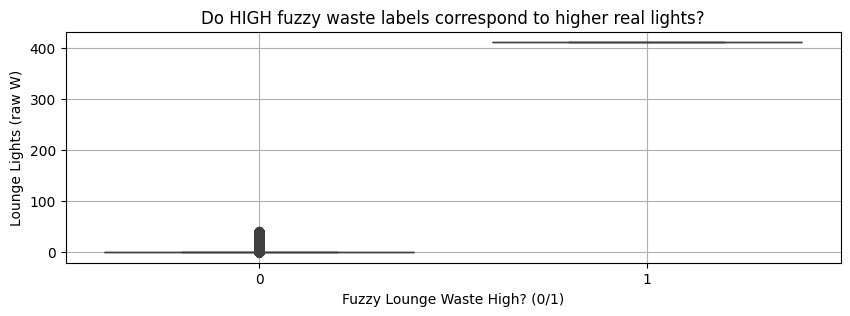

In [29]:

# 4) Boxplot: do HIGH fuzzy waste labels correspond to higher real lights?

# Use mean as threshold just for illustration
waste_indicator = (validation_df["lounge_waste_fuzzy"] >
              validation_df["lounge_waste_fuzzy"].mean()).astype(int)

plt.figure(figsize=(10,3))
sns.boxplot(x=waste_indicator, y=validation_df['lounge_lights_raw'])
plt.xlabel("Fuzzy Lounge Waste High? (0/1)")
plt.ylabel("Lounge Lights (raw W)")
plt.title("Do HIGH fuzzy waste labels correspond to higher real lights?")
plt.grid(True)
plt.show()



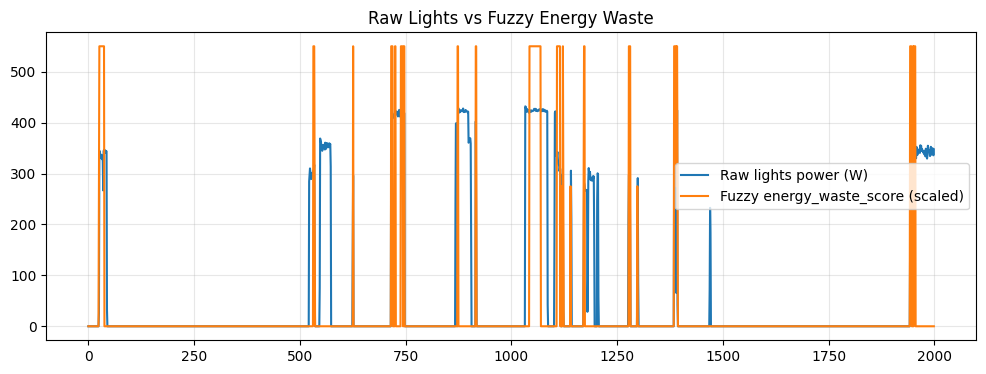

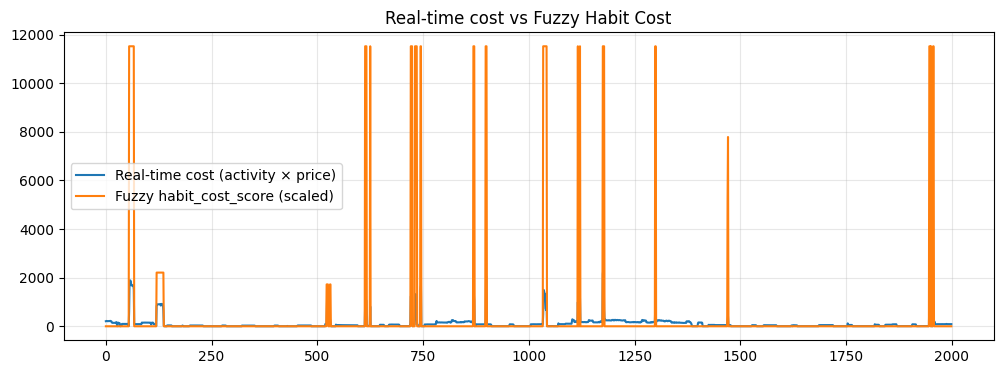

In [30]:

window = slice(0, 2000)

# Raw lights vs fuzzy energy waste
raw_lights = validation_df["kitchen_lights_raw"] + validation_df["lounge_lights_raw"]
waste_score = validation_df["energy_waste_score"]

plt.figure(figsize=(12,4))
plt.plot(raw_lights.iloc[window].values, label='Raw lights power (W)')
plt.plot(waste_score.iloc[window].values * raw_lights.max(),
         label='Fuzzy energy_waste_score (scaled)')
plt.title('Raw Lights vs Fuzzy Energy Waste')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Raw cost proxy vs fuzzy habit cost
raw_cost_proxy = validation_df["activity_total_raw"] * validation_df["price_raw"]
habit_score = validation_df["habit_cost_fuzzy"]

plt.figure(figsize=(12,4))
plt.plot(raw_cost_proxy.iloc[window].values, label='Real-time cost (activity × price)')
plt.plot(habit_score.iloc[window].values * raw_cost_proxy.max(),
         label='Fuzzy habit_cost_score (scaled)')
plt.title('Real-time cost vs Fuzzy Habit Cost')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


1. Raw Lights vs Fuzzy Energy Waste plot shows how spikes in total lighting power align with increases in the fuzzy energy-waste score. The FIS correctly flags periods where lights are on despite low activity by producing high waste peaks.

2. Estimated Real-time cost vs Fuzzy Habit Cost plot compares the raw cost proxy (activity × price) with the FIS habit-cost score. The fuzzy habit-cost output rises sharply during high-price, high-usage periods, confirming that the FIS correctly captures cost-intensive behavior.

In [31]:

# 6) Simple correlations for reporting (same window, just for numbers in the text)
corr_lights = np.corrcoef(raw_lights.iloc[window], waste_score.iloc[window])[0,1]
corr_cost   = np.corrcoef(raw_cost_proxy.iloc[window], habit_score.iloc[window])[0,1]

print("Correlation raw_lights vs energy_waste_score:", corr_lights)
print("Correlation raw_cost_proxy vs habit_cost_score:", corr_cost)


Correlation raw_lights vs energy_waste_score: 0.5073938021522763
Correlation raw_cost_proxy vs habit_cost_score: 0.8411996681560243


The correlation between raw lighting power and the fuzzy energy waste score was 0.51, indicating a somewhat good correlation. This is to be expected, given that waste detection is affected by activity and time of day, as well as light magnitude.

The correlation between a raw cost proxy (activity × spot price) and the fuzzy habit cost score was 0.84, indicating significant alignment between fuzzy reasoning and cost fluctuations.

These results show that the fuzzy approach accurately captures real-world use patterns while maintaining interpretability and non-linear reasoning beyond straight numerical thresholds.